# Statistical Arbitrage

Implementation of *Statistical Arbitrage in the U.S. Equities Market*:  Avellaneda, Marco and Lee, Jeong-Hyun, Statistical Arbitrage in the U.S. Equities Market (July 11, 2008). Available at SSRN: https://ssrn.com/abstract=1153505 or http://dx.doi.org/10.2139/ssrn.1153505 

Statistical arbitrage, more commonly referred to as **StatArb**, is a trading strategy that relies on mean reversion to predict the future returns of an asset. In this implementation, if a stock begins to outperfom its industry sector ETF (e.g., Google outperforming XLK ETF), mean reversion predicts that the stock will soon revert toward the mean perfomance of its sector ETF. Thus, a short position is taken in order to (hopefully) profit from this prediction. If a stock underpforms its sector ETF, we instead go long on the stock, hoping to profit

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm
import warnings
warnings.filterwarnings("ignore")

### Import Data for JPM, XLF, and SPY

JPM is the stock we assume will obey the mean reversion principle. XLF is the ETF for the financial sector, and SPY is an ETF that tracks the S&P500 (tracks the general market). To simplify a relatively complicated model, we go short when JPM outperforms XLF, and we go long when JPM underperforms relative to XLF. We also look at how JPM is performing relative to the general market (SPY). Effectively, we assume that XLF is a good representation of the financial sector and thus forms the base for our strategy.

In [2]:
jpm = yf.download('JPM', start='2018-01-01', end='2025-01-01')
xlf = yf.download('XLF', start='2018-01-01', end='2025-01-01')
spy = yf.download('SPY', start='2018-01-01', end='2025-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


We now need to calculate the close-to-close log returns for each asset. Log returns are preferred to simple returns because this time-series data. For a more in-depth discussion of simple vs. log returns, check out this link: https://gregorygundersen.com/blog/2022/02/06/log-returns

In [3]:
c2clr = pd.DataFrame()

# JPM
c2clr.index = jpm.index
c2clr['JPM'] = np.NaN
for i in range (1, len(c2clr['JPM'])):
    c2clr['JPM'].iloc[i] = np.log(jpm['Close'].iloc[i]) - np.log(jpm['Close'].iloc[i-1])

# XLF
c2clr['XLF'] = np.NaN
for i in range (1, len(c2clr['XLF'])):
    c2clr['XLF'].iloc[i] = np.log(xlf['Close'].iloc[i]) - np.log(xlf['Close'].iloc[i-1])

# SPY
c2clr['SPY'] = np.NaN
for i in range (1, len(c2clr['SPY'])):
    c2clr['SPY'].iloc[i] = np.log(spy['Close'].iloc[i]) - np.log(spy['Close'].iloc[i-1])

c2clr.dropna(inplace=True)

When we visualize the returns for all three assets, we can see that they move in sync with one another.

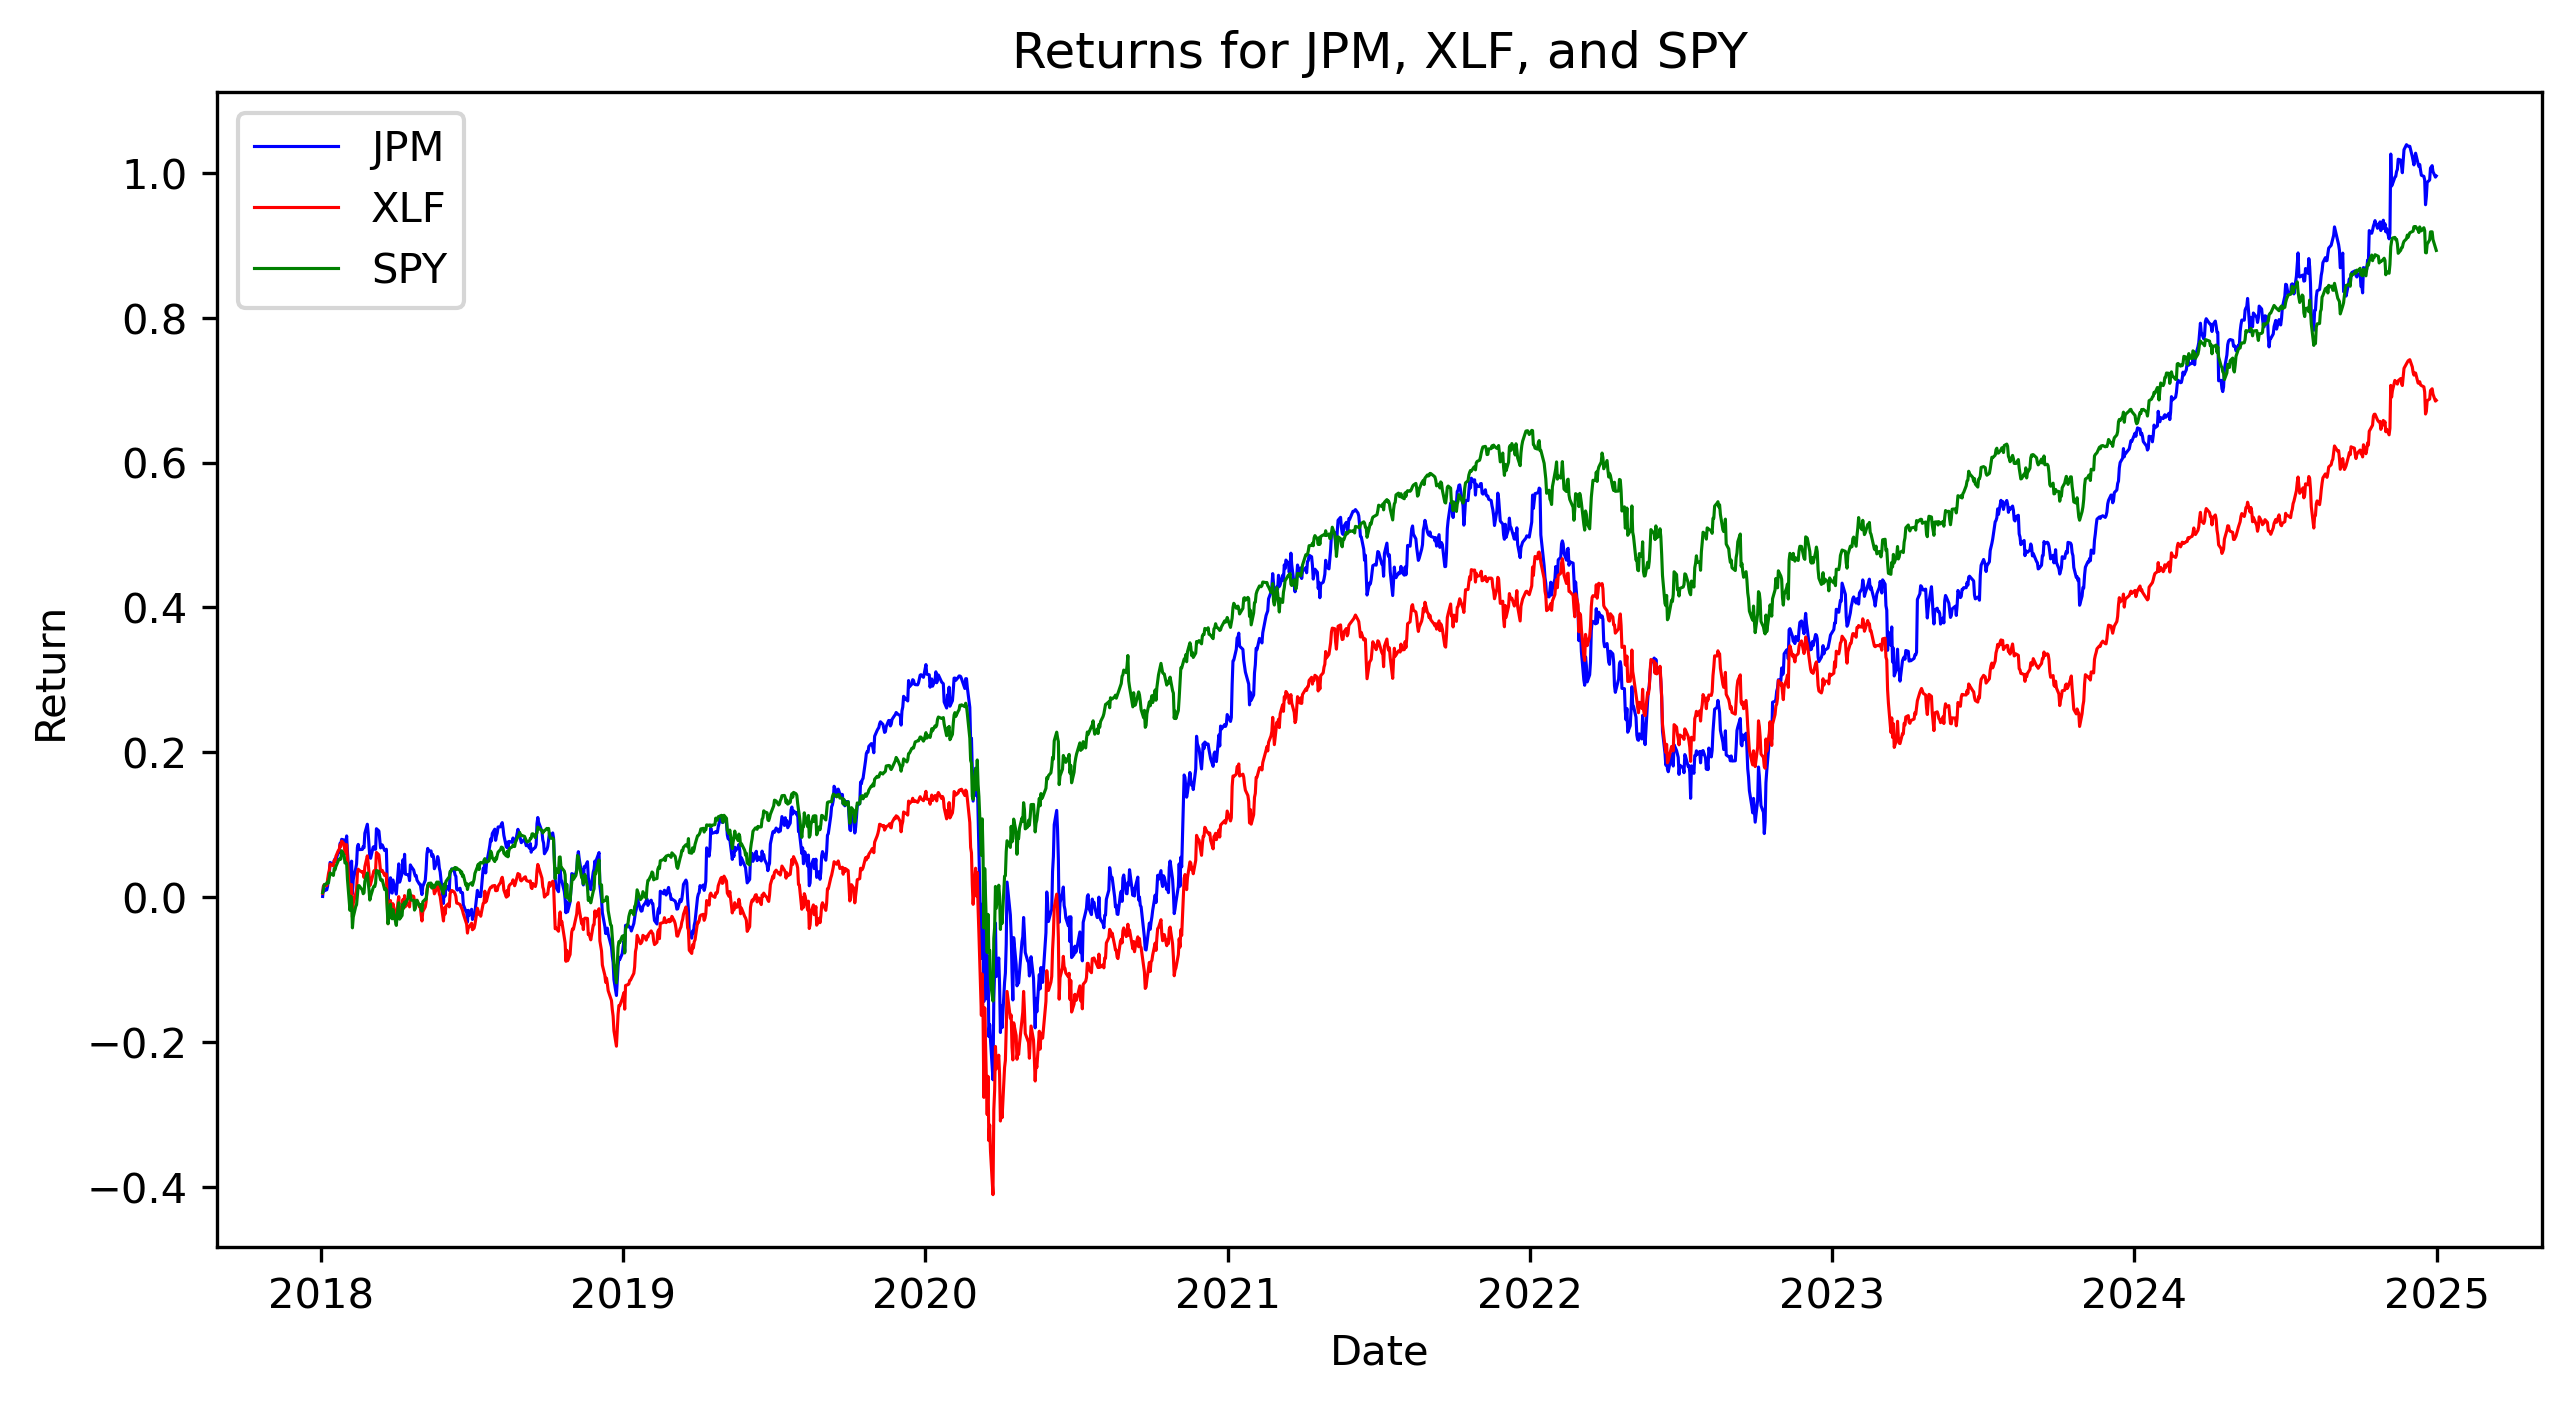

In [4]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(c2clr.index, c2clr['JPM'].cumsum(), label='JPM', color='blue', linewidth=0.75)
plt.plot(c2clr.index, c2clr['XLF'].cumsum(), label='XLF', color='red', linewidth=0.75)
plt.plot(c2clr.index, c2clr['SPY'].cumsum(), label='SPY', color='green', linewidth=0.75)
plt.xlabel("Date")
plt.ylabel("Return")
plt.title('Returns for JPM, XLF, and SPY')
plt.legend()
plt.show()

**Key Takeaway:** All three are moving in sync. We know that XLF includes JPM, which means we can capitalize on differences in performance between the two.

### StatArb Model

We can start to understand StatArb by thinking about pairs trading. Say we have two securities A and B. If we assume that the two securities are correlated in some way, we can make trading decisions depending on their price difference. This means are variable of interest is

$e=P_A-P_B$

where $P_A$ and $P_B$ are the prices of the two securities. If $e$ becomes swings far enough in either the positive or negative direction, we will enter into a trade (either a long or short position depending on the direction of the swing). That means we need to do two things:

**1. Find out if two (or more) stocks are correlated in some way (cointegration analysis).**
<br>
**2. Model how that correlation evolves over time.**

### Cointegration Analysis

In [5]:
model = sm.ols(formula='JPM ~ 1 + XLF + SPY', data=c2clr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    JPM   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     5720.
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:08:49   Log-Likelihood:                 6290.1
No. Observations:                1760   AIC:                        -1.257e+04
Df Residuals:                    1757   BIC:                        -1.256e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      1.364      0.173   -9.68e-05       0.001
XLF            1.3853      0.020     68.555      0.000       1.346       1.425
SPY           -0.3847      0.025    -15.329      0.000      -0.434      -0.336
==============================================================================
Omnibus:                      336.207   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8900.498
Skew:                           0.046   Prob(JB):                         0.00
Kurtosis:                      14.016   Cond. No.                         192.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Key Takeaway:** From the model, we can see that JPM as a $\beta$ of 1.37 relative to XLF, which means that JPM is more volatile that the ETF. Similarly, JPM has a $\beta$ of -0.38 relative to the SPY, meaning it roughly moves opposite the general market. We can model JPM's return as

$JPM=1.37XLF-0.38SPY$

This is our **economic factor model**, which describes how an asset trades/performs relative to its sector specific market and the general market. What we need to do next is find out what this model *doesn't* explain and figure out how to model that missing information.

### The Reversion Regression

Any difference between this model and reality can be explained by the sum of the residuals over time. The paper calls this the **auxiliary process** and this is the data used to perform the reversion regression.

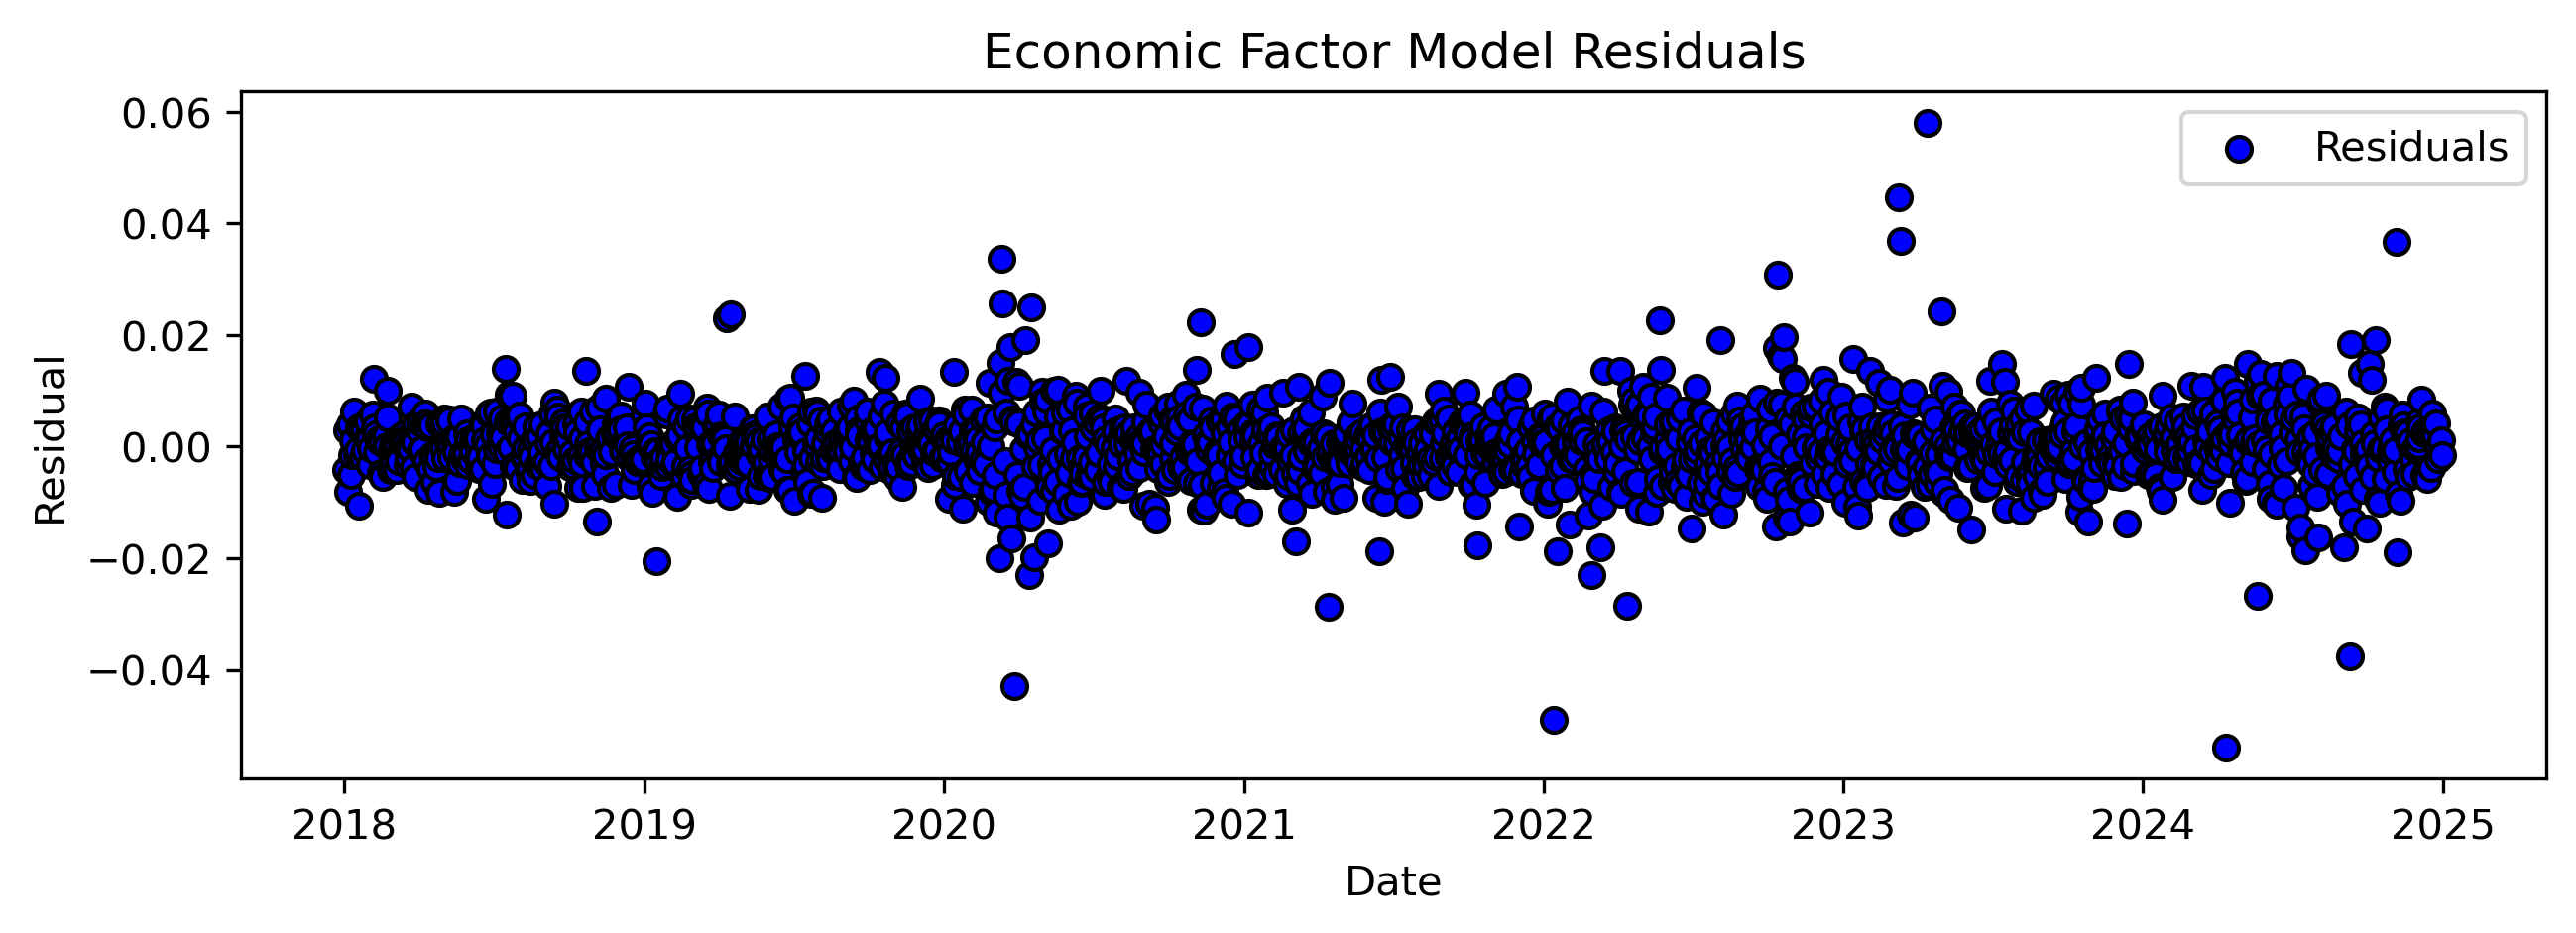

In [6]:
plt.figure(figsize=(10, 3), dpi=300)
plt.scatter(c2clr.index, model.resid, label='Residuals', color='blue', ec='black')
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title('Economic Factor Model Residuals')
plt.legend()
plt.show()

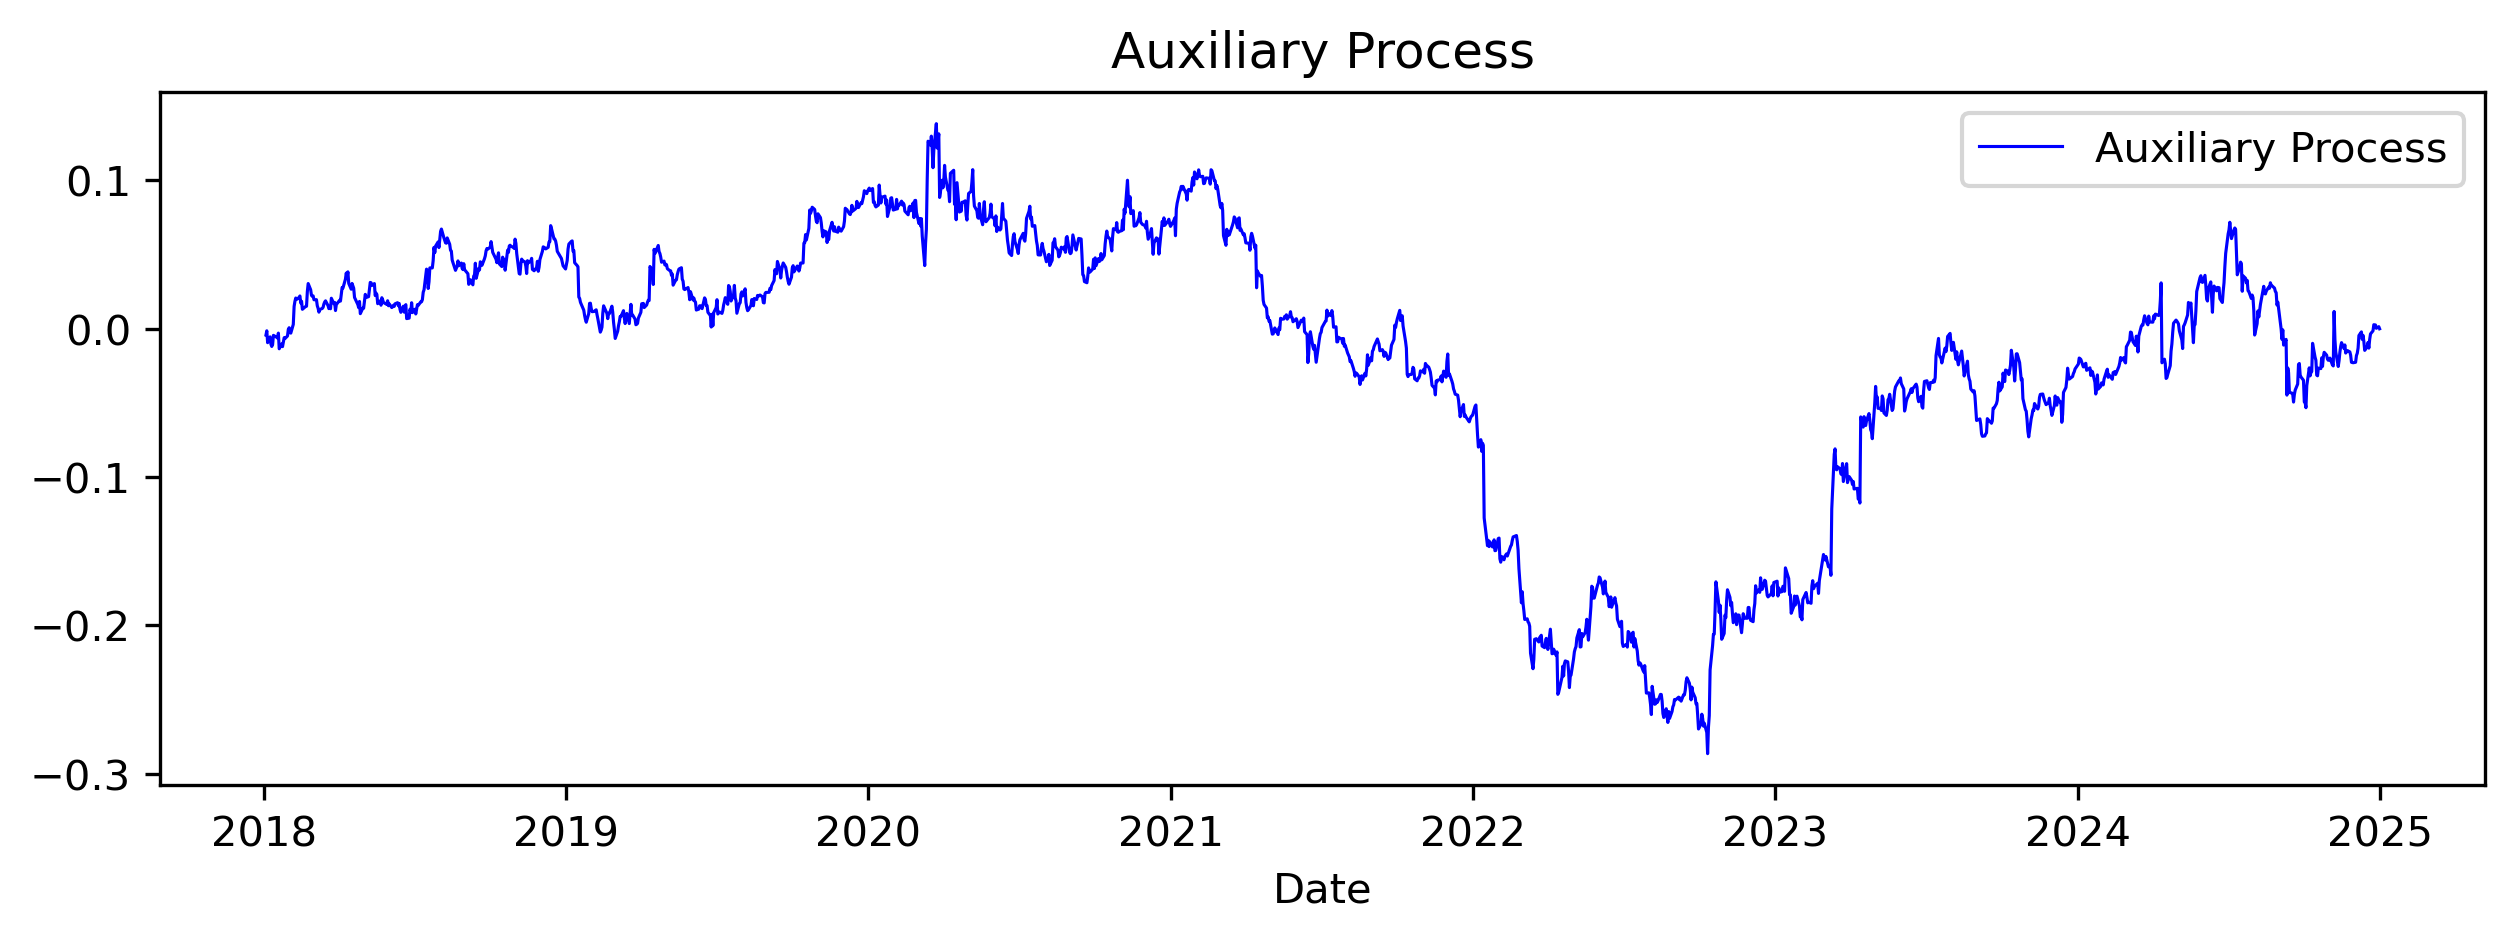

In [7]:
plt.figure(figsize=(10, 3), dpi=300)
plt.plot(c2clr.index, np.cumsum(model.resid), label='Auxiliary Process', color='blue', linewidth=0.75)
plt.xlabel("Date")
plt.title('Auxiliary Process')
plt.legend()
plt.show()

**The central idea underpinning this entire model is that the auxiliary process can be modeled using an Ornstein-Uhlenbeck (OU) process.** I learned about this in my statistical mechanics class, so it's interesting to see it applied to financial data. In phyiscs, we use the OU process to model the motion of a particle under friction. More specifically, the Ornstein-Uhlenbeck process is interpreted as Brownian motion in a harmonic potential. An OU process is a specific type of differential equation that displays mean reversion behavior. If the process diverges away from its mean, it will eventually be forced back. It is of the form

$dX_i(t)=\kappa_i(m_i-X_i(t))dt+\sigma_i{d}W_i(t)$, $\kappa_i>0$

This process is stationary and auto-regressive with lag 1 (AR-1 model). In particular, the increment $dX_i(t)$ has unconditional mean zero and conditional mean equal to

$E\{dX_i(t)|X_i(s),s\leq{t}\}=\kappa_i(m_i-X_i(t))dt$

The conditional mean, or forecast of expected daily returns, is positive or negative according to the sign of $m_i − X_i(t)$. The parameters in the differential equation are specific to each stock and they are assumed to avry slowly in relation to the Brownian motion increments $dW_i(t)$ in the time window of interest. The paper estimates that the statistics for the residual process on a window length of 60 days, assuming that the parameters are constant over the window.

The next step is to fit the OU process described above onto the cumulative sum of the residuals from the first model (auxiliary process). **If the residuals do in fact have some sort of structure or pattern then this implies that our economic factor model was missing some variable of interest that explains the difference between our model and reality.**

In [8]:
X = np.cumsum(model.resid)
Xdf = pd.DataFrame()
Xdf.index = X.index
Xdf['y'] = np.NaN
Xdf['x'] = np.NaN
for i in range (1, len(Xdf.index)-1):
    Xdf['y'].iloc[i] = X.iloc[i+1]
    Xdf['x'].iloc[i] = X.iloc[i-1]
OUFit = sm.ols(formula='y ~ 1 + x', data=Xdf).fit()
OUFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.649e+05
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        08:08:49   Log-Likelihood:                 5694.9
No. Observations:                1758   AIC:                        -1.139e+04
Df Residuals:                    1756   BIC:                        -1.137e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.192e-05      0.000     -0.399      0.690      -0.001       0.000
x              0.9947      0.002    406.118      0.000       0.990       1.000
==============================================================================
Omnibus:                      334.093   Durbin-Watson:                   1.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5375.315
Skew:                           0.404   Prob(JB):                         0.00
Kurtosis:                      11.528   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see above, there is in fact a pattern in the auxiliary process. Now, we take the coefficients from the fit and transform them into the parameters listed in the paper.

In [9]:
varEta = np.var(OUFit.resid)
a, b = OUFit.params
k = -1 * np.log(b) * 252
m = a / (1-b)
sigma = np.sqrt((varEta * 2 * k) / (1 - b**2))
sigma_eq = np.sqrt(varEta / (1 - b**2))
[m, sigma_eq]

[-0.017431188635269372, 0.09244859072739417]

We can now compute the s-score as presented in the paper. The s-score defines what action we should take. Specifically, if

$s_i<-\bar{s}_{bo}$ buy to open
<br>
$s_i>+\bar{s}_{so}$ sell to open
<br>
$s_i<+\bar{s}_{bc}$ close short position
<br>
$s_i>-\bar{s}_{sc}$ close long position

where the cutoffs are determined empirically. Entering a trade (i.e., buy to open) means buy one dollar of the corresponding stock and selling $\beta_i$ dollars of its sector ETF or, in the case of using multiple factors, $\beta_{i1}$ dollars of ETF 1, $\beta_{i2}$ dollars of ETF 2, ..., and $\beta_{im}$ dollars of ETF m. Similarly, closing a long position means selling a stock and buying ETFs. Based on analysis, the authors of the paper found that the following are good choices for s-score cutoffs:

$\bar{s}_{bo}=\bar{s}_{so}=1.25$
<br>
$\bar{s}_{bc}=0.75$
<br>
$\bar{s}_{sc}=0.50$

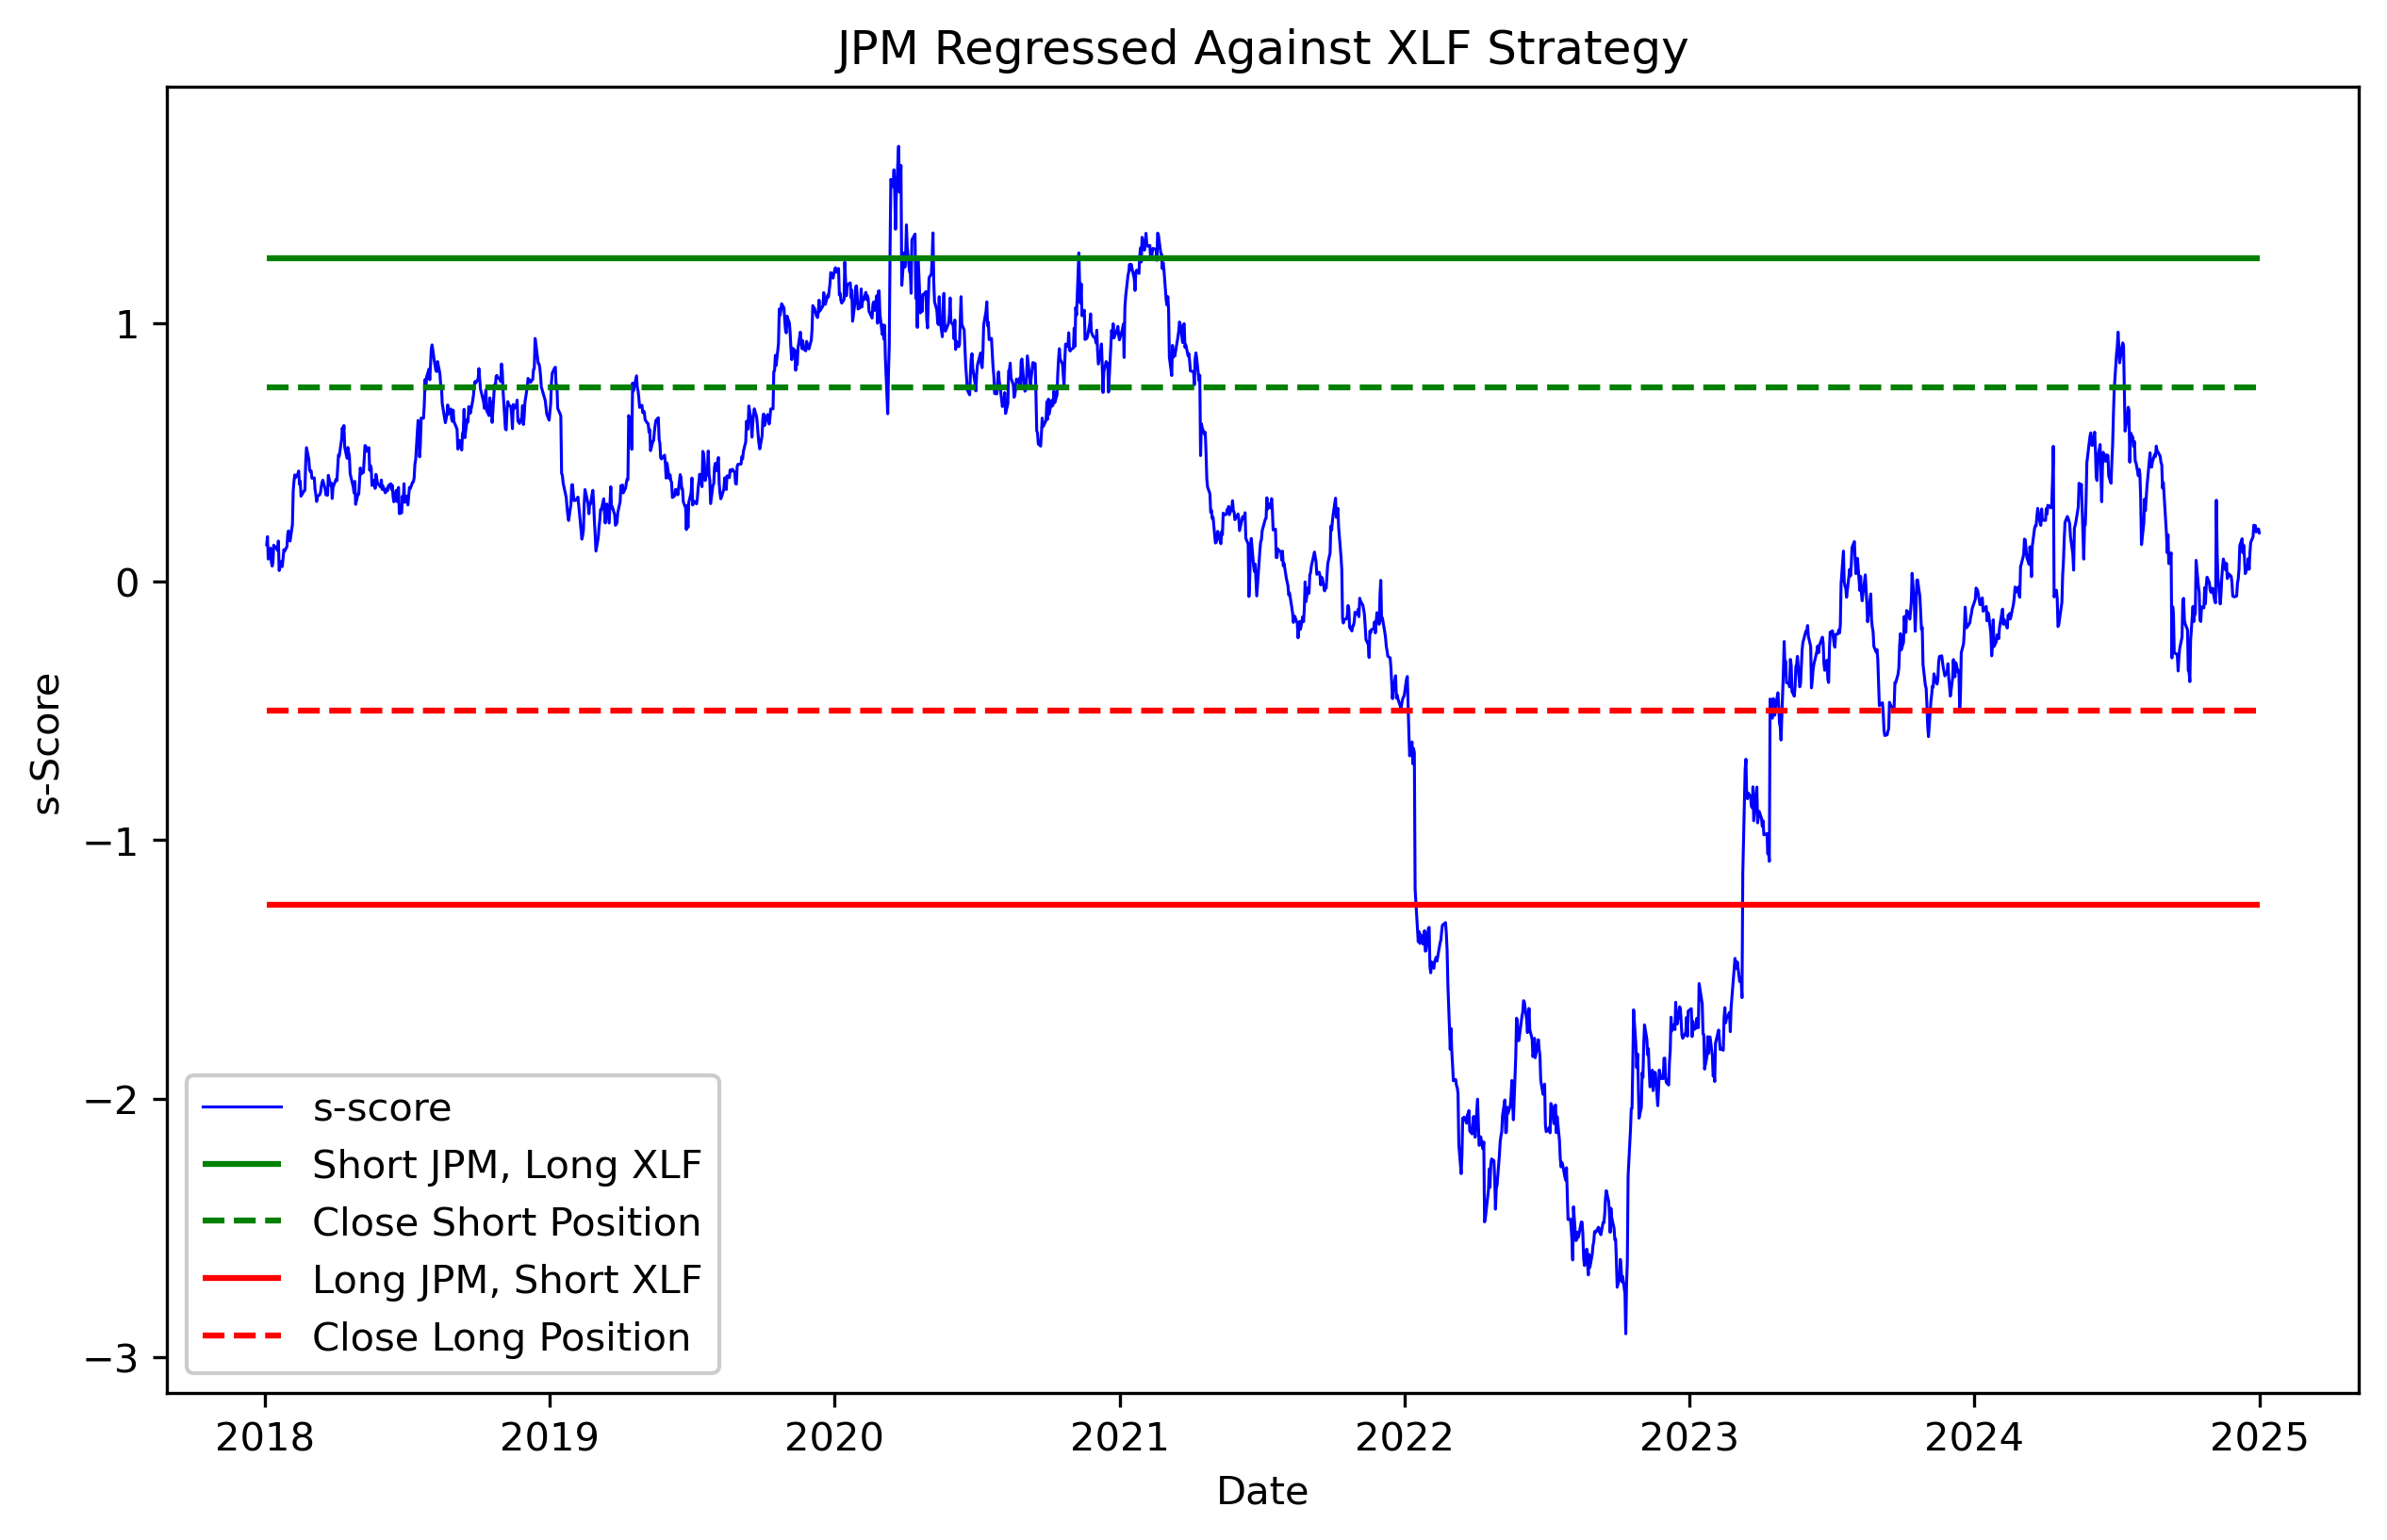

In [10]:
c2clr['sscore'] = (X - m) / sigma_eq
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(c2clr.index, c2clr.sscore, label="s-score", color='blue', linewidth=0.75)
xmin = c2clr.index[0]
xmax = c2clr.index[-1]
plt.hlines([1.25], xmin, xmax, color='green', label='Short JPM, Long XLF')
plt.hlines([0.75], xmin, xmax, color='green', linestyles='--', label='Close Short Position')
plt.hlines([-1.25], xmin, xmax, color='red', label='Long JPM, Short XLF')
plt.hlines([-0.5], xmin, xmax, color='red', linestyles='--', label='Close Long Position')
plt.xlabel("Date")
plt.ylabel("s-Score")
plt.title('JPM Regressed Against XLF Strategy')
plt.legend(framealpha=1, loc='lower left')
plt.show()

**But does it make money?**

### Backtesting

In [11]:
paramsRes = []
for i in range(90, len(c2clr) - 90):
    # Subsetting c2clr
    c2clr_sub = c2clr.iloc[i:(i + 90), :]

    # Standardizing columns JPM, XLF, SPY
    c2clr_sub['JPM'] = (c2clr_sub['JPM'] - c2clr_sub['JPM'].mean()) / c2clr_sub['JPM'].std()
    c2clr_sub['XLF'] = (c2clr_sub['XLF'] - c2clr_sub['XLF'].mean()) / c2clr_sub['XLF'].std()
    c2clr_sub['SPY'] = (c2clr_sub['SPY'] - c2clr_sub['SPY'].mean()) / c2clr_sub['SPY'].std()

    # Regression model: JPM ~ XLF + SPY
    macroRegr = sm.ols('JPM ~ 1 + XLF + SPY', data=c2clr_sub).fit()

    # Cumulative sum of residuals
    residuals_macro = macroRegr.resid
    auxData = np.cumsum(residuals_macro)

    auxdf = pd.DataFrame()
    auxdf.index = auxData.index
    auxdf['y'] = np.NaN
    auxdf['x'] = np.NaN
    for j in range (1, len(auxdf.index)-1):
        auxdf['y'].iloc[j] = auxData.iloc[j+1]
        auxdf['x'].iloc[j] = auxData.iloc[j-1]

    ouRegr = sm.ols(formula='y ~ 1 + x', data=auxdf).fit()

    # Extracting required coefficients and calculating sigma, sigma_eq
    varEta = np.var(ouRegr.resid)
    a, b = ouRegr.params
    k = -np.log(b) * 252
    m = a / (1 - b)
    sigma = np.sqrt((varEta * 2 * k) / (1 - b**2))
    sigma_eq = np.sqrt(varEta / (1 - b**2))

    # Storing results in the list
    paramsRes.append({
        'Date': c2clr_sub.index[-1],
        'MacroBeta_XLF': macroRegr.params['XLF'],
        'MacroBeta_SPY': macroRegr.params['SPY'],
        'MacroAlpha': macroRegr.params['Intercept'],
        'VarEta': varEta,
        'OUA': a,
        'OUB': b,
        'OUK': k,
        'Sigma': sigma,
        'SigmaEQ': sigma_eq,
        'Score': -m / sigma_eq
    })

# Converting the results into a DataFrame
paramsRes_df = pd.DataFrame(paramsRes)

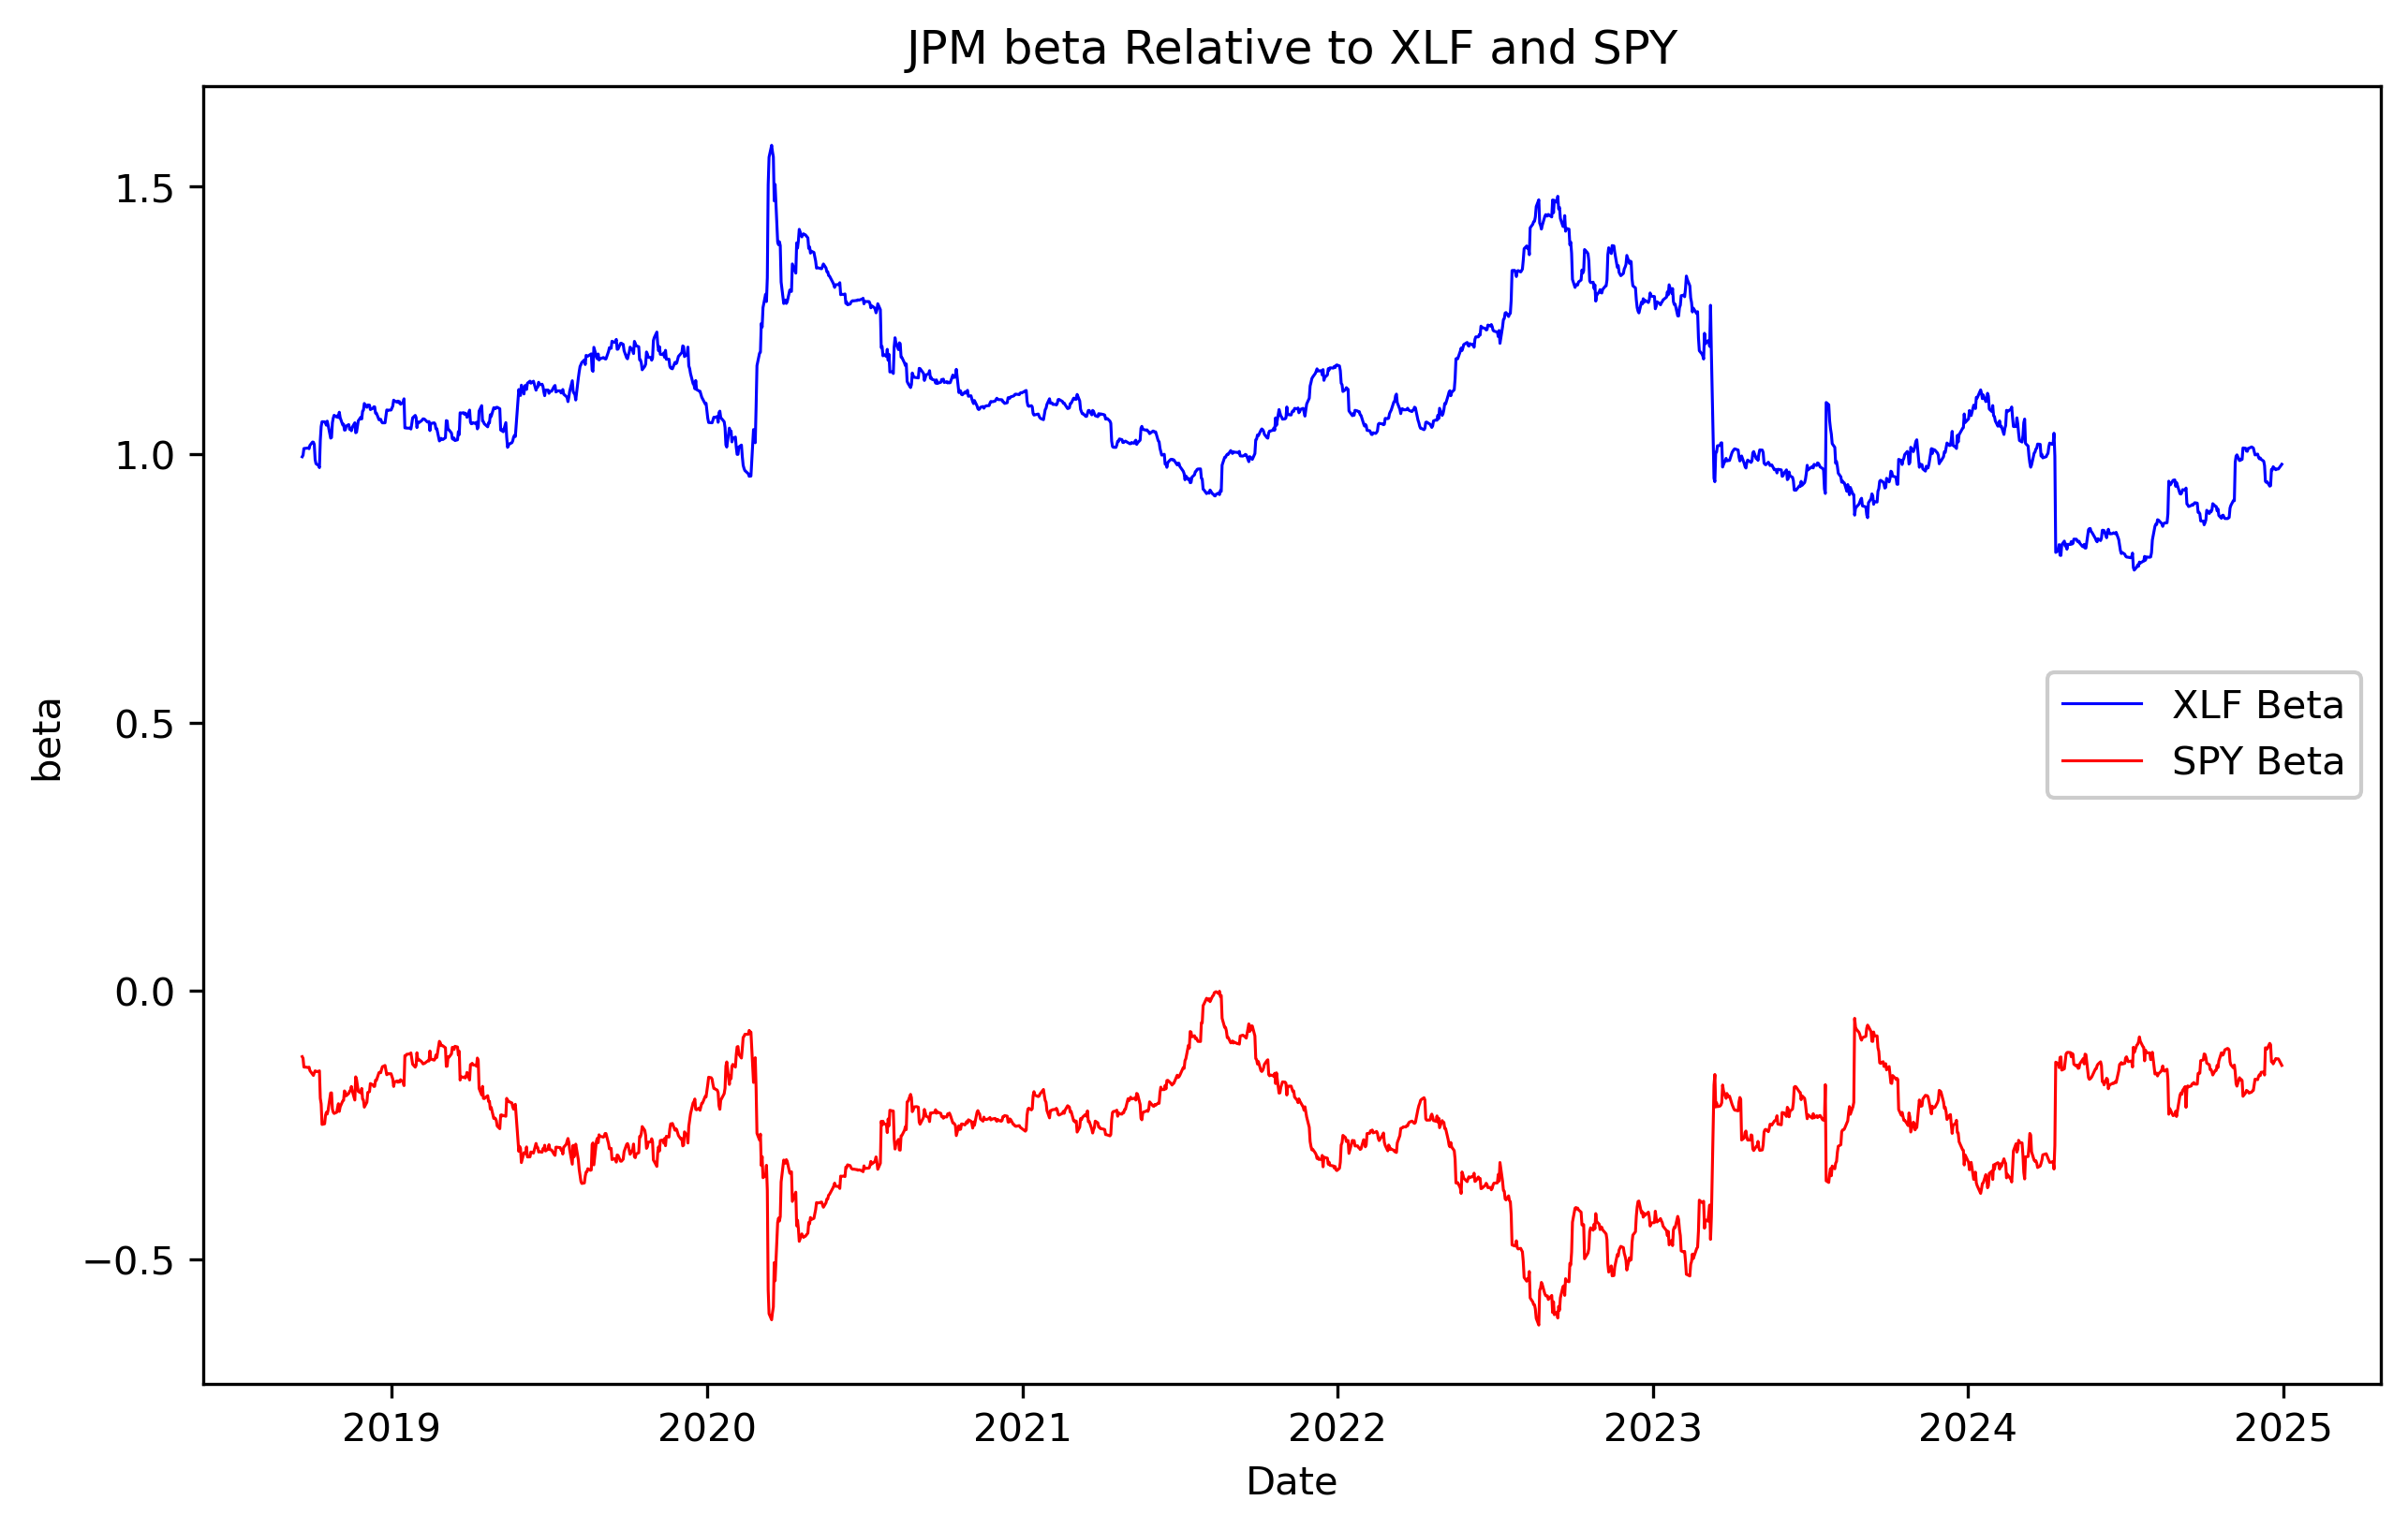

In [12]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(paramsRes_df.Date, paramsRes_df.MacroBeta_XLF, label="XLF Beta", color='blue', linewidth=0.75)
plt.plot(paramsRes_df.Date, paramsRes_df.MacroBeta_SPY, label="SPY Beta", color='red', linewidth=0.75)
plt.xlabel("Date")
plt.ylabel("beta")
plt.title('JPM beta Relative to XLF and SPY')
plt.legend(framealpha=1, loc='center right')
plt.show()

The graph above is a good sign. We want to see that the signs are consistent and that both beta values don't vary too much. The key thing to note is that in the OU process, we care a lot about the speed of the mean reversion ($\kappa$) as we don't want to take a position that is too slow to revert to the mean. In the paper, they suggest making sure the reversion happens within half of the estimation period. We are using 60 days as our estimation window, so the horizontal line shows our minimum k value.

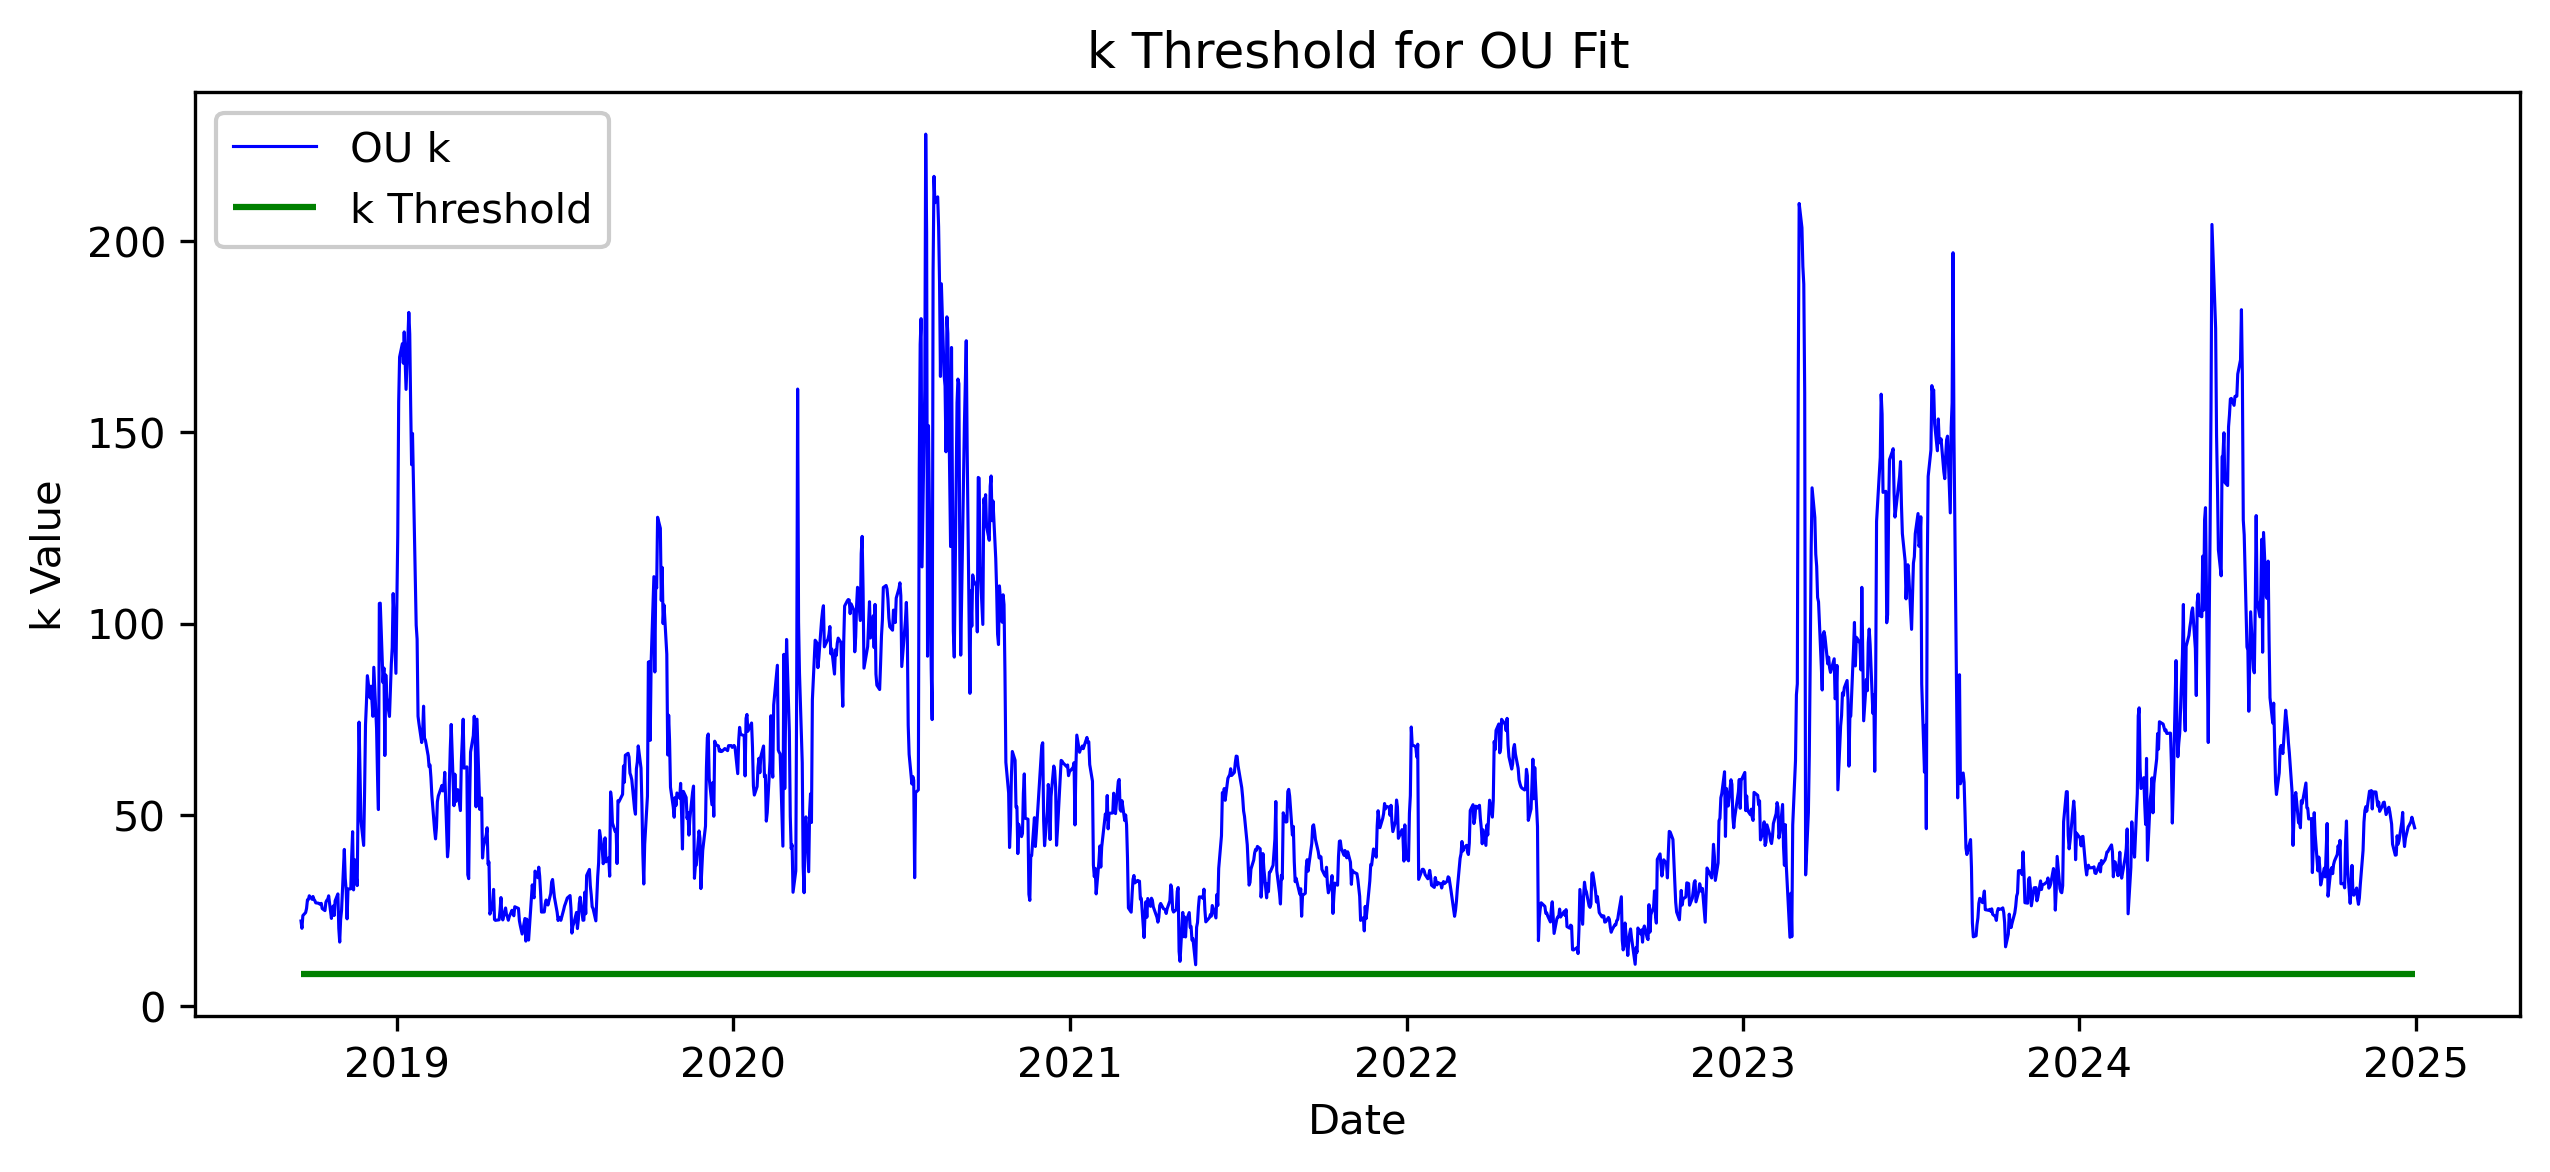

In [13]:
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(paramsRes_df.Date, paramsRes_df.OUK, label="OU k", color='blue', linewidth=0.75)
xmin = paramsRes_df.Date.iloc[0]
xmax = paramsRes_df.Date.iloc[-1]
plt.hlines([252/30], xmin, xmax, color='green', label='k Threshold')
plt.xlabel("Date")
plt.ylabel("k Value")
plt.title('k Threshold for OU Fit')
plt.legend(framealpha=1, loc='upper left')
plt.show()

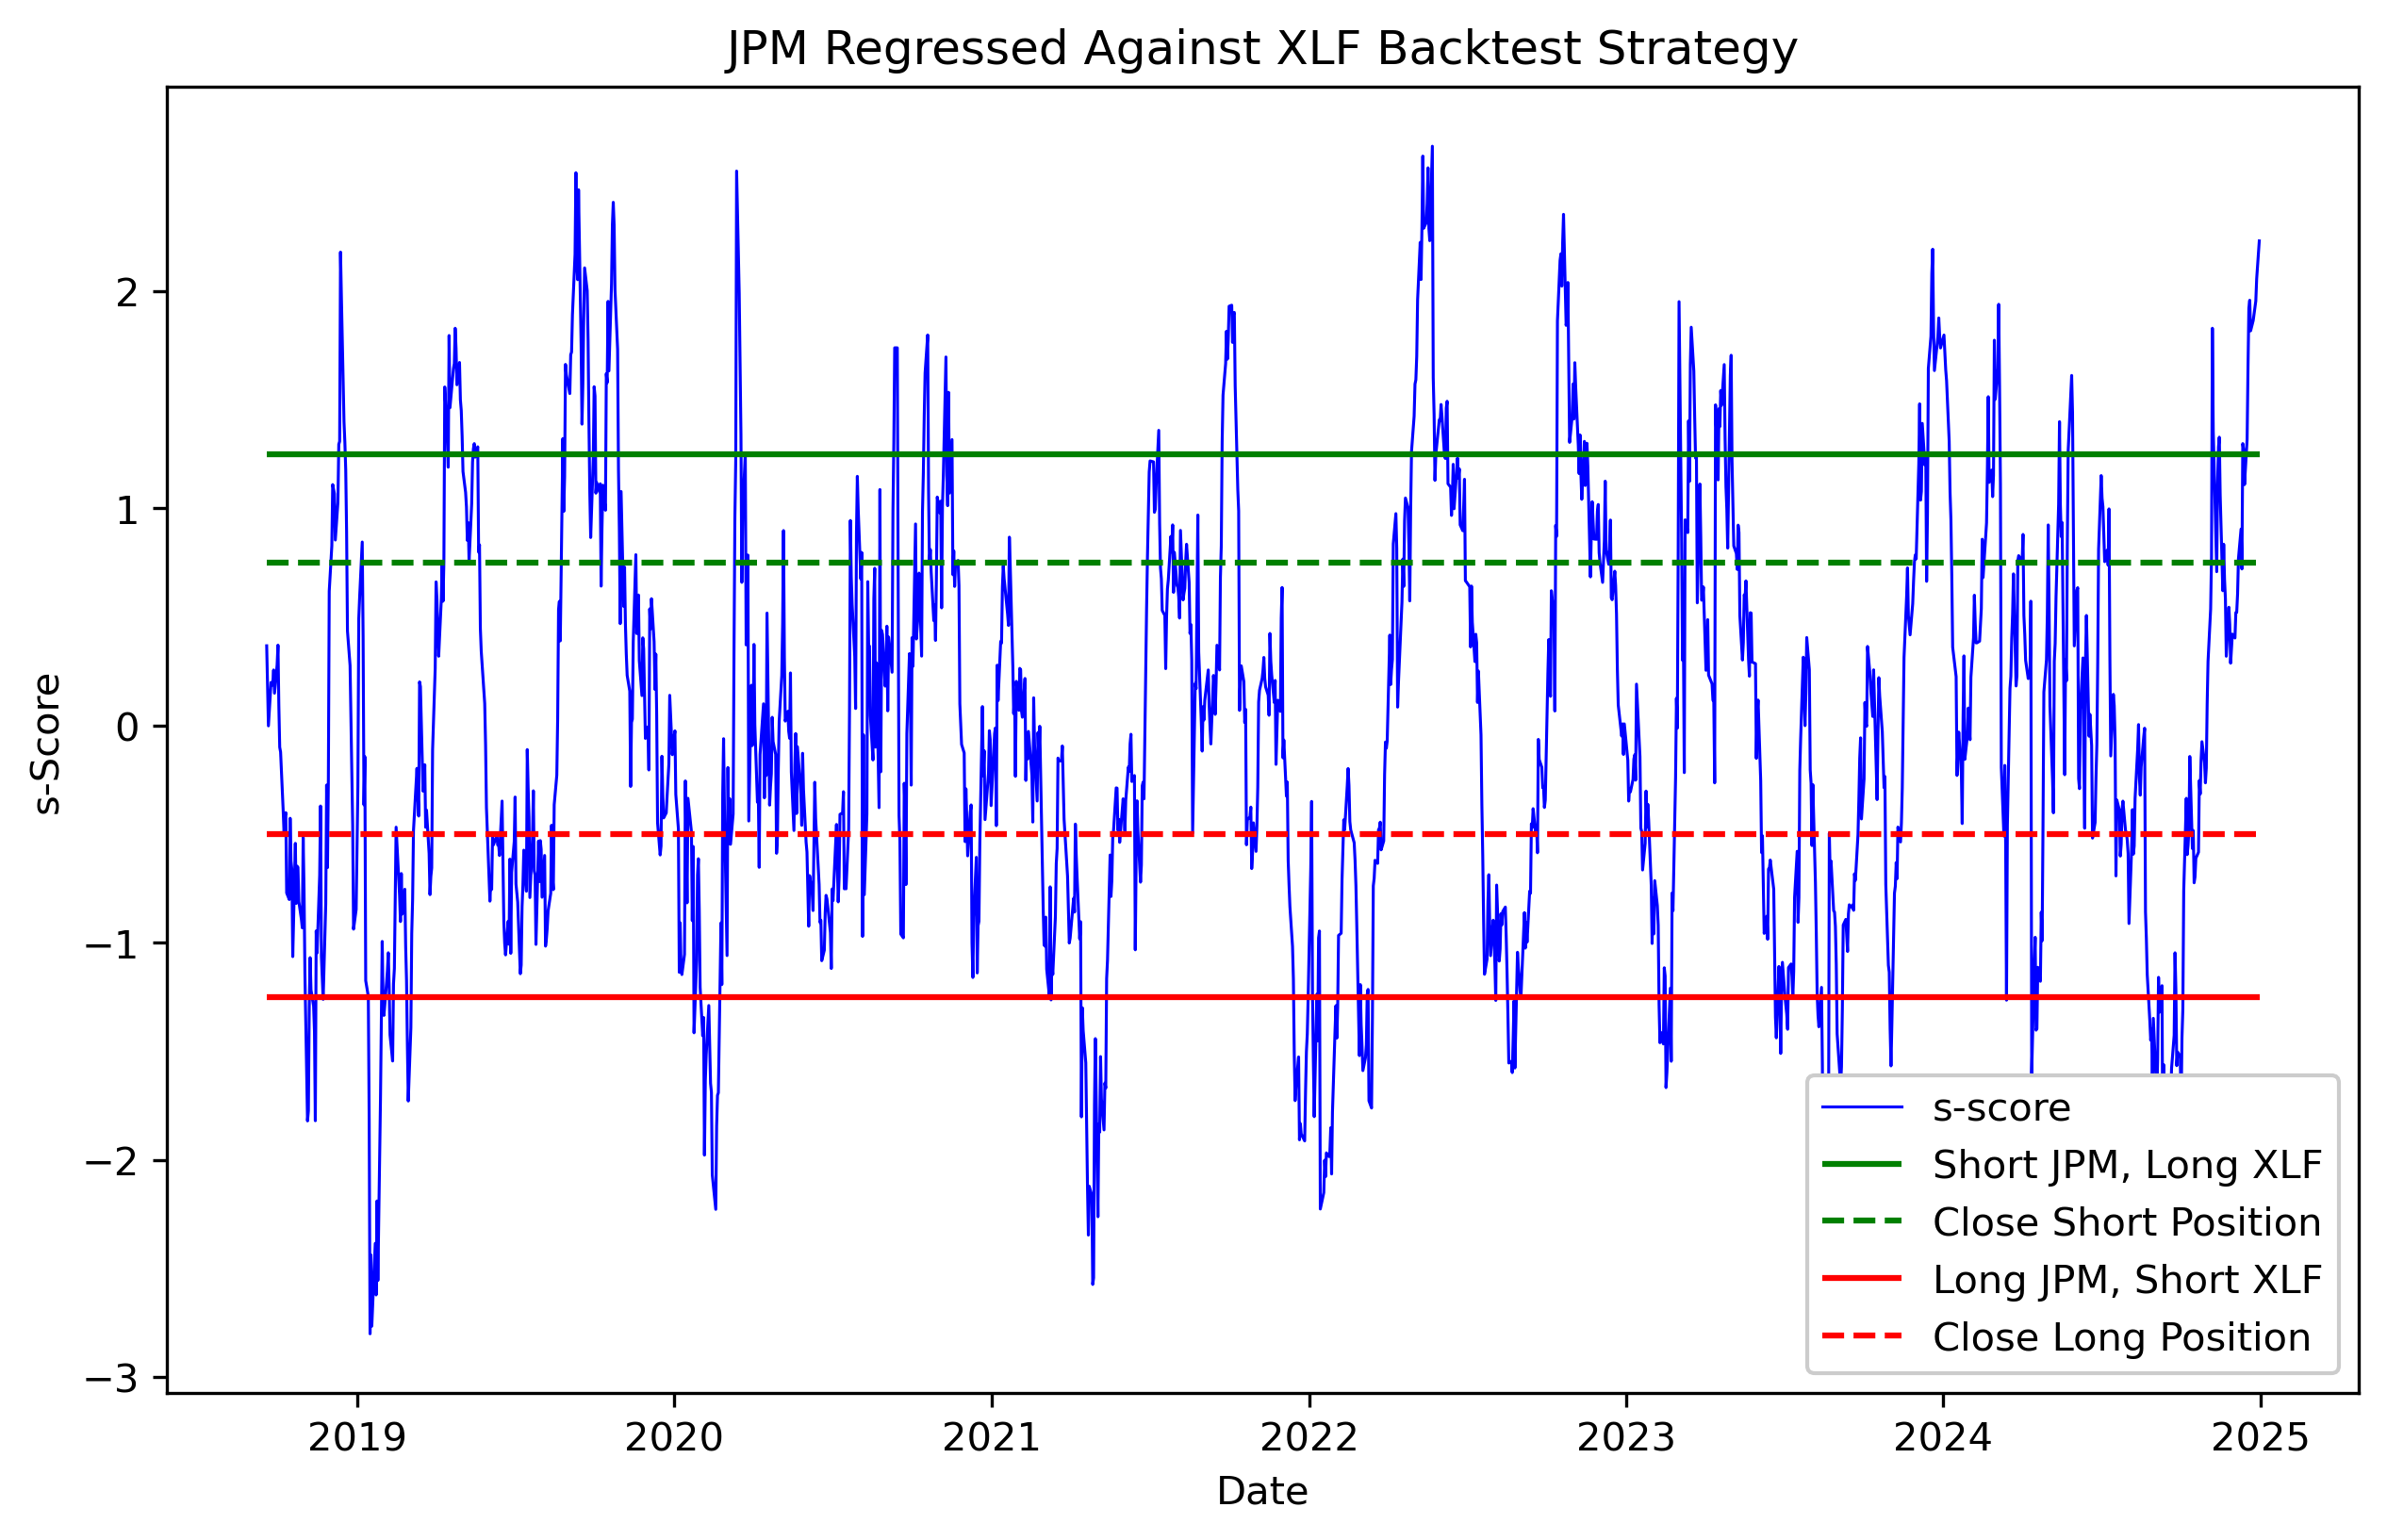

In [14]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(paramsRes_df.Date, paramsRes_df.Score, label="s-score", color='blue', linewidth=0.75)
xmin = paramsRes_df.Date.iloc[0]
xmax = paramsRes_df.Date.iloc[-1]
plt.hlines([1.25], xmin, xmax, color='green', label='Short JPM, Long XLF')
plt.hlines([0.75], xmin, xmax, color='green', linestyles='--', label='Close Short Position')
plt.hlines([-1.25], xmin, xmax, color='red', label='Long JPM, Short XLF')
plt.hlines([-0.5], xmin, xmax, color='red', linestyles='--', label='Close Long Position')
plt.xlabel("Date")
plt.ylabel("s-Score")
plt.title('JPM Regressed Against XLF Backtest Strategy')
plt.legend(framealpha=1, loc='lower right')
plt.show()

In [15]:
copyParamsRes_df = paramsRes_df.copy()
copyC2CLR = c2clr.copy()
paramsRes_df['JPM_Pos'] = 0
paramsRes_df['XLF_Pos'] = 0
paramsRes_df['SPY_Pos'] = 0

for i in range(1, len(paramsRes_df)):
    if paramsRes_df.OUK.iloc[i] > (252/30):
        if paramsRes_df.Score.iloc[i] >= 1.25:
            paramsRes_df.JPM_Pos.iloc[i] = -1
            paramsRes_df.XLF_Pos.iloc[i] = paramsRes_df.MacroBeta_XLF.iloc[i]
            paramsRes_df.SPY_Pos.iloc[i] = paramsRes_df.MacroBeta_SPY.iloc[i]
        elif paramsRes_df.Score.iloc[i] >= 0.75 and paramsRes_df.JPM_Pos.iloc[i-1] == -1:
            paramsRes_df.JPM_Pos.iloc[i] = -1
            paramsRes_df.XLF_Pos.iloc[i] = paramsRes_df.MacroBeta_XLF.iloc[i]    
            paramsRes_df.SPY_Pos.iloc[i] = paramsRes_df.MacroBeta_SPY.iloc[i]

        if paramsRes_df.Score[i] <= -1.25:
            paramsRes_df.JPM_Pos.iloc[i] = 1
            paramsRes_df.XLF_Pos.iloc[i] = -1 * paramsRes_df.MacroBeta_XLF.iloc[i]   
            paramsRes_df.SPY_Pos.iloc[i] = -1 * paramsRes_df.MacroBeta_SPY.iloc[i]
        elif paramsRes_df.Score.iloc[i] <= -0.5 and paramsRes_df.JPM_Pos.iloc[i-1] == 1:
            paramsRes_df.JPM_Pos.iloc[i] = 1
            paramsRes_df.XLF_Pos.iloc[i] = -1 * paramsRes_df.MacroBeta_XLF.iloc[i] 
            paramsRes_df.SPY_Pos.iloc[i] = -1 * paramsRes_df.MacroBeta_SPY.iloc[i]

In [16]:
c2clr['NextJPM'] = c2clr['JPM'].shift(-1)
c2clr['NextXLF'] = c2clr['XLF'].shift(-1)
c2clr['NextSPY'] = c2clr['SPY'].shift(-1)
c2clr.reset_index(inplace=True)

# Perform the left join on 'Date' column
paramsRes_df = pd.merge(paramsRes_df, c2clr[['Date', 'NextJPM', 'NextXLF', 'NextSPY']], on='Date', how='left')

# Calculate return
paramsRes_df['Return'] = (paramsRes_df['NextJPM'] * paramsRes_df['JPM_Pos'] +
                       paramsRes_df['NextXLF'] * paramsRes_df['XLF_Pos'] +
                       paramsRes_df['NextSPY'] * paramsRes_df['SPY_Pos'])

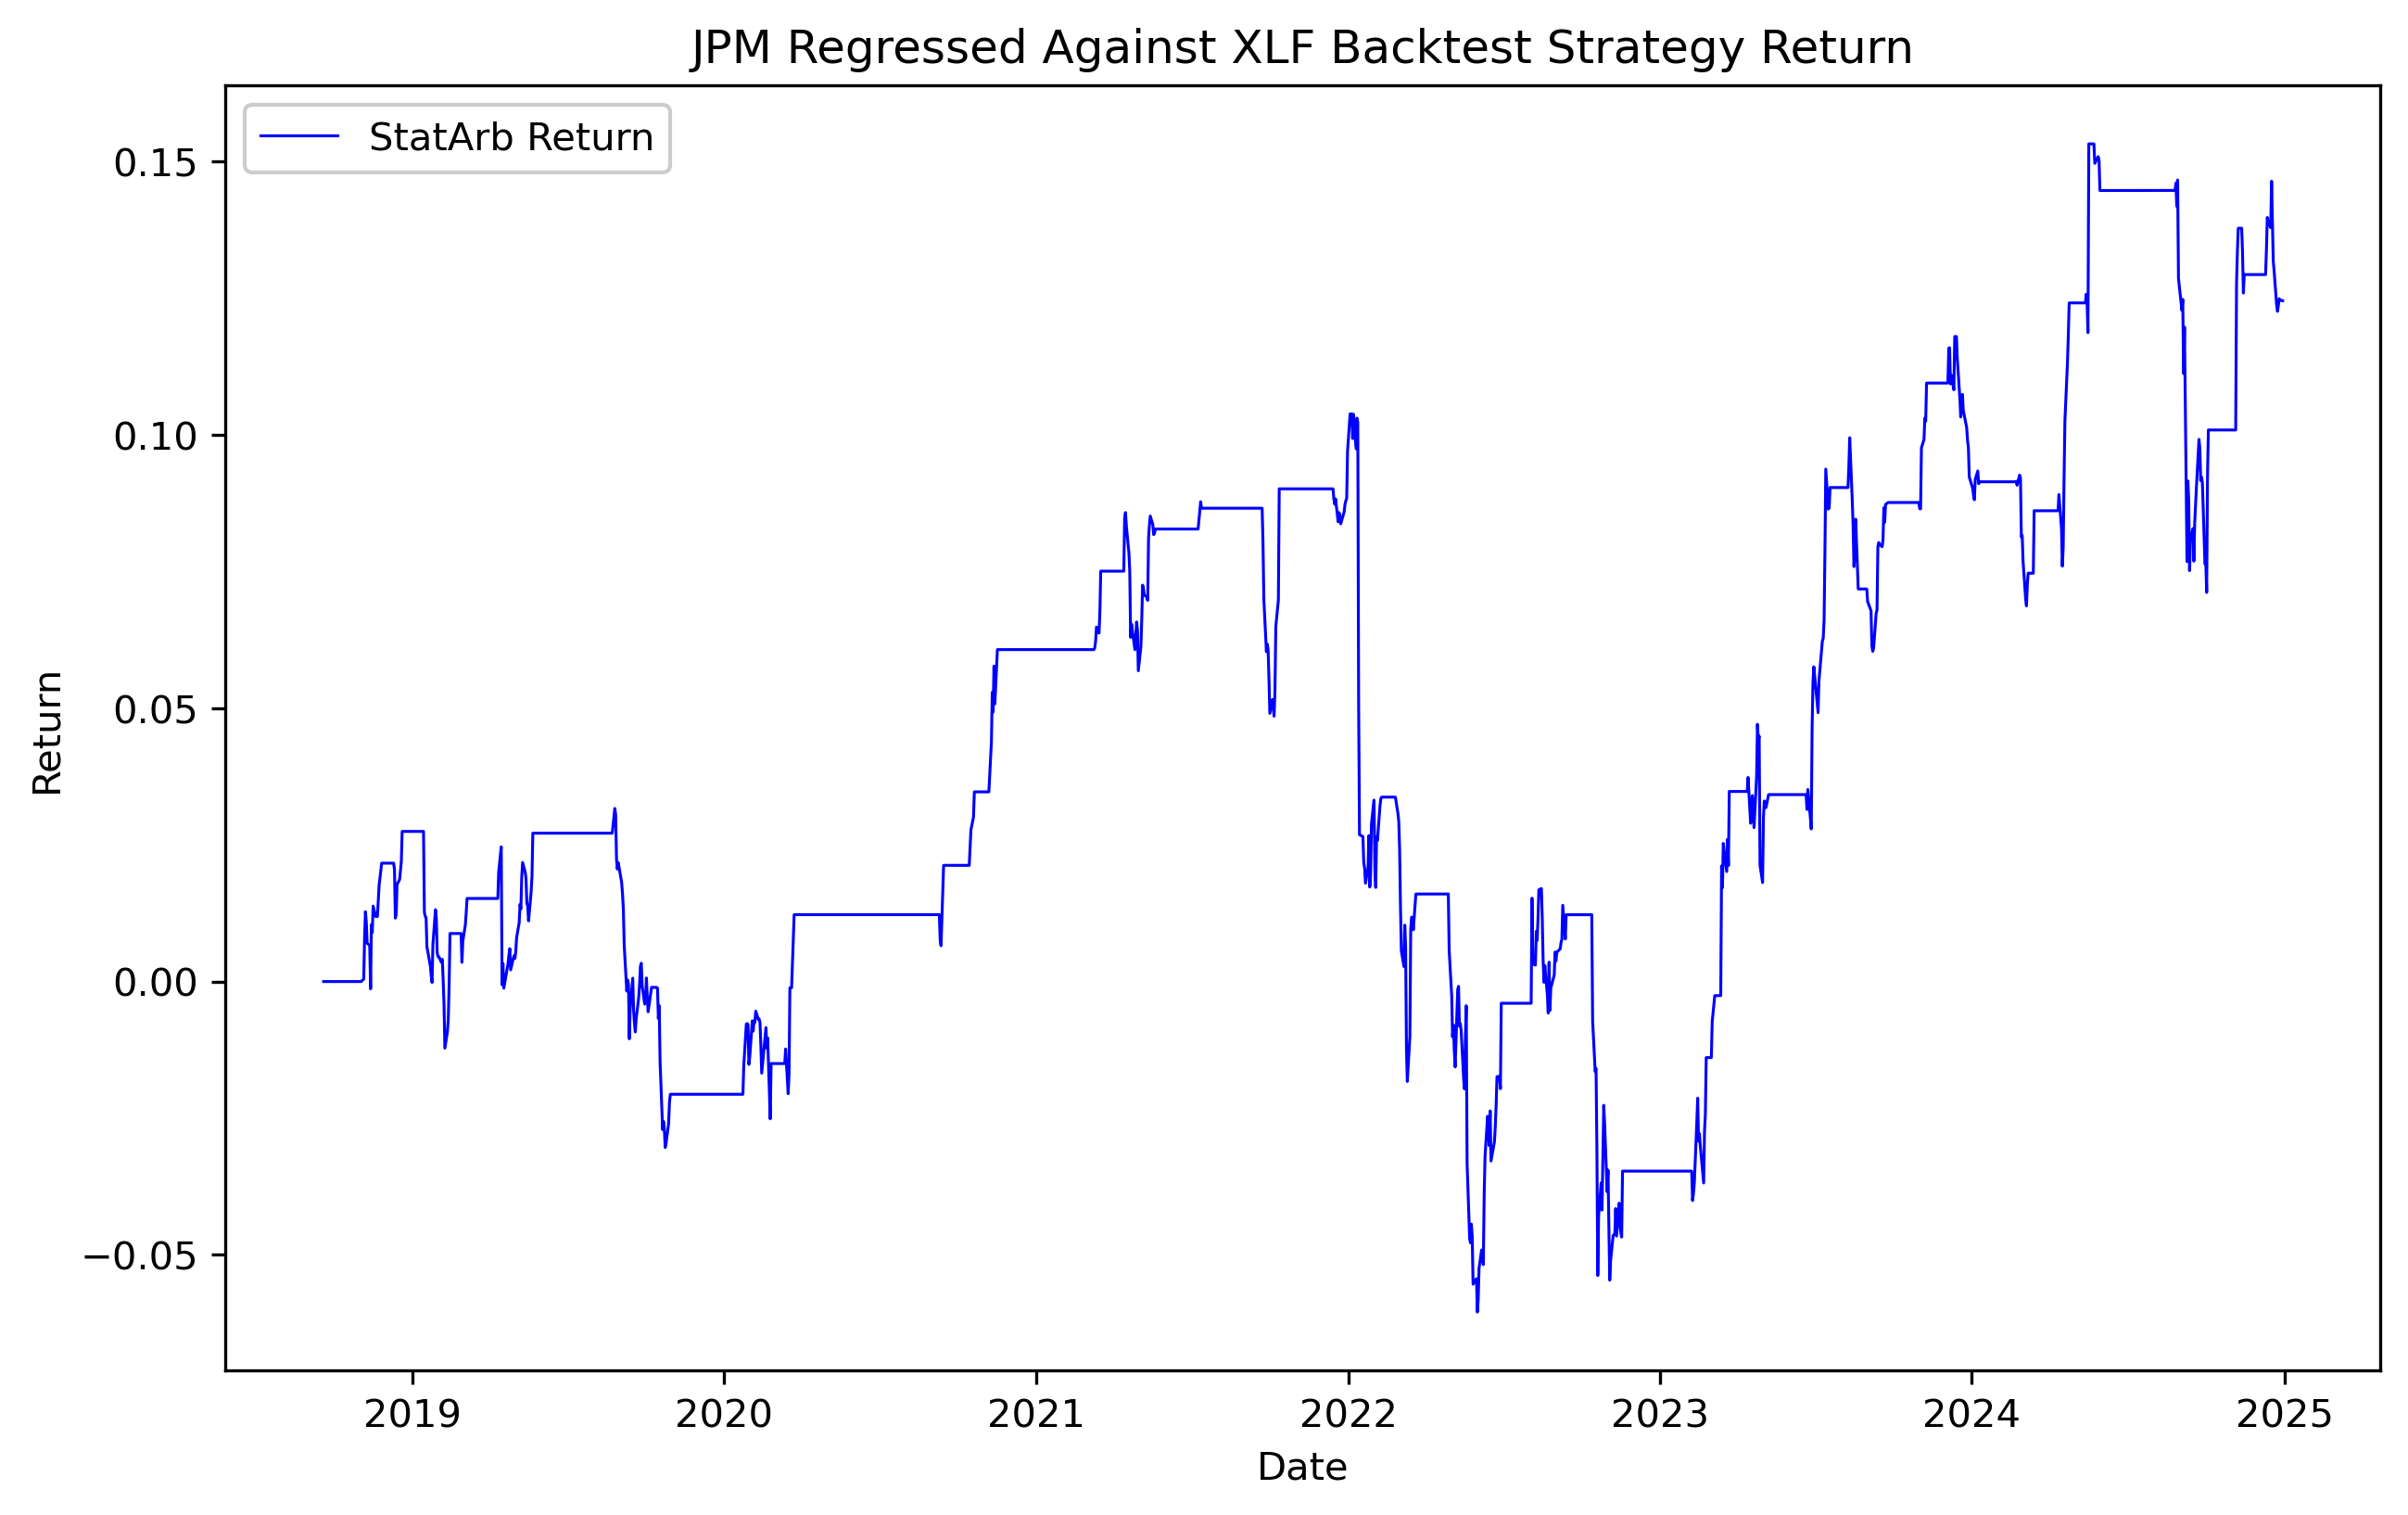

In [17]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(paramsRes_df.Date, np.cumsum(paramsRes_df.Return), label="StatArb Return", color='blue', linewidth=0.75)
plt.xlabel("Date")
plt.ylabel("Return")
plt.title('JPM Regressed Against XLF Backtest Strategy Return')
plt.legend(framealpha=1, loc='upper left')
plt.show()

In [18]:
print(f'Cumulative Return: {np.cumsum(paramsRes_df.Return).iloc[-1] * 100:.2f}%')
print(f'Sharpe Ratio: {paramsRes_df['Return'].mean() / paramsRes_df['Return'].std() * np.sqrt(252)}')
s = (paramsRes_df.Return+1).cumprod()
max_drawdown = np.ptp(s)/s.max()
print(f'Max Drawdown: {max_drawdown}')

Cumulative Return: 12.46%
Sharpe Ratio: 0.2880036669760711
Max Drawdown: 0.18800486797903487


**We made money!** 12.46% on our money isn't bad, right? Turns out, we could have done **A LOT** better.

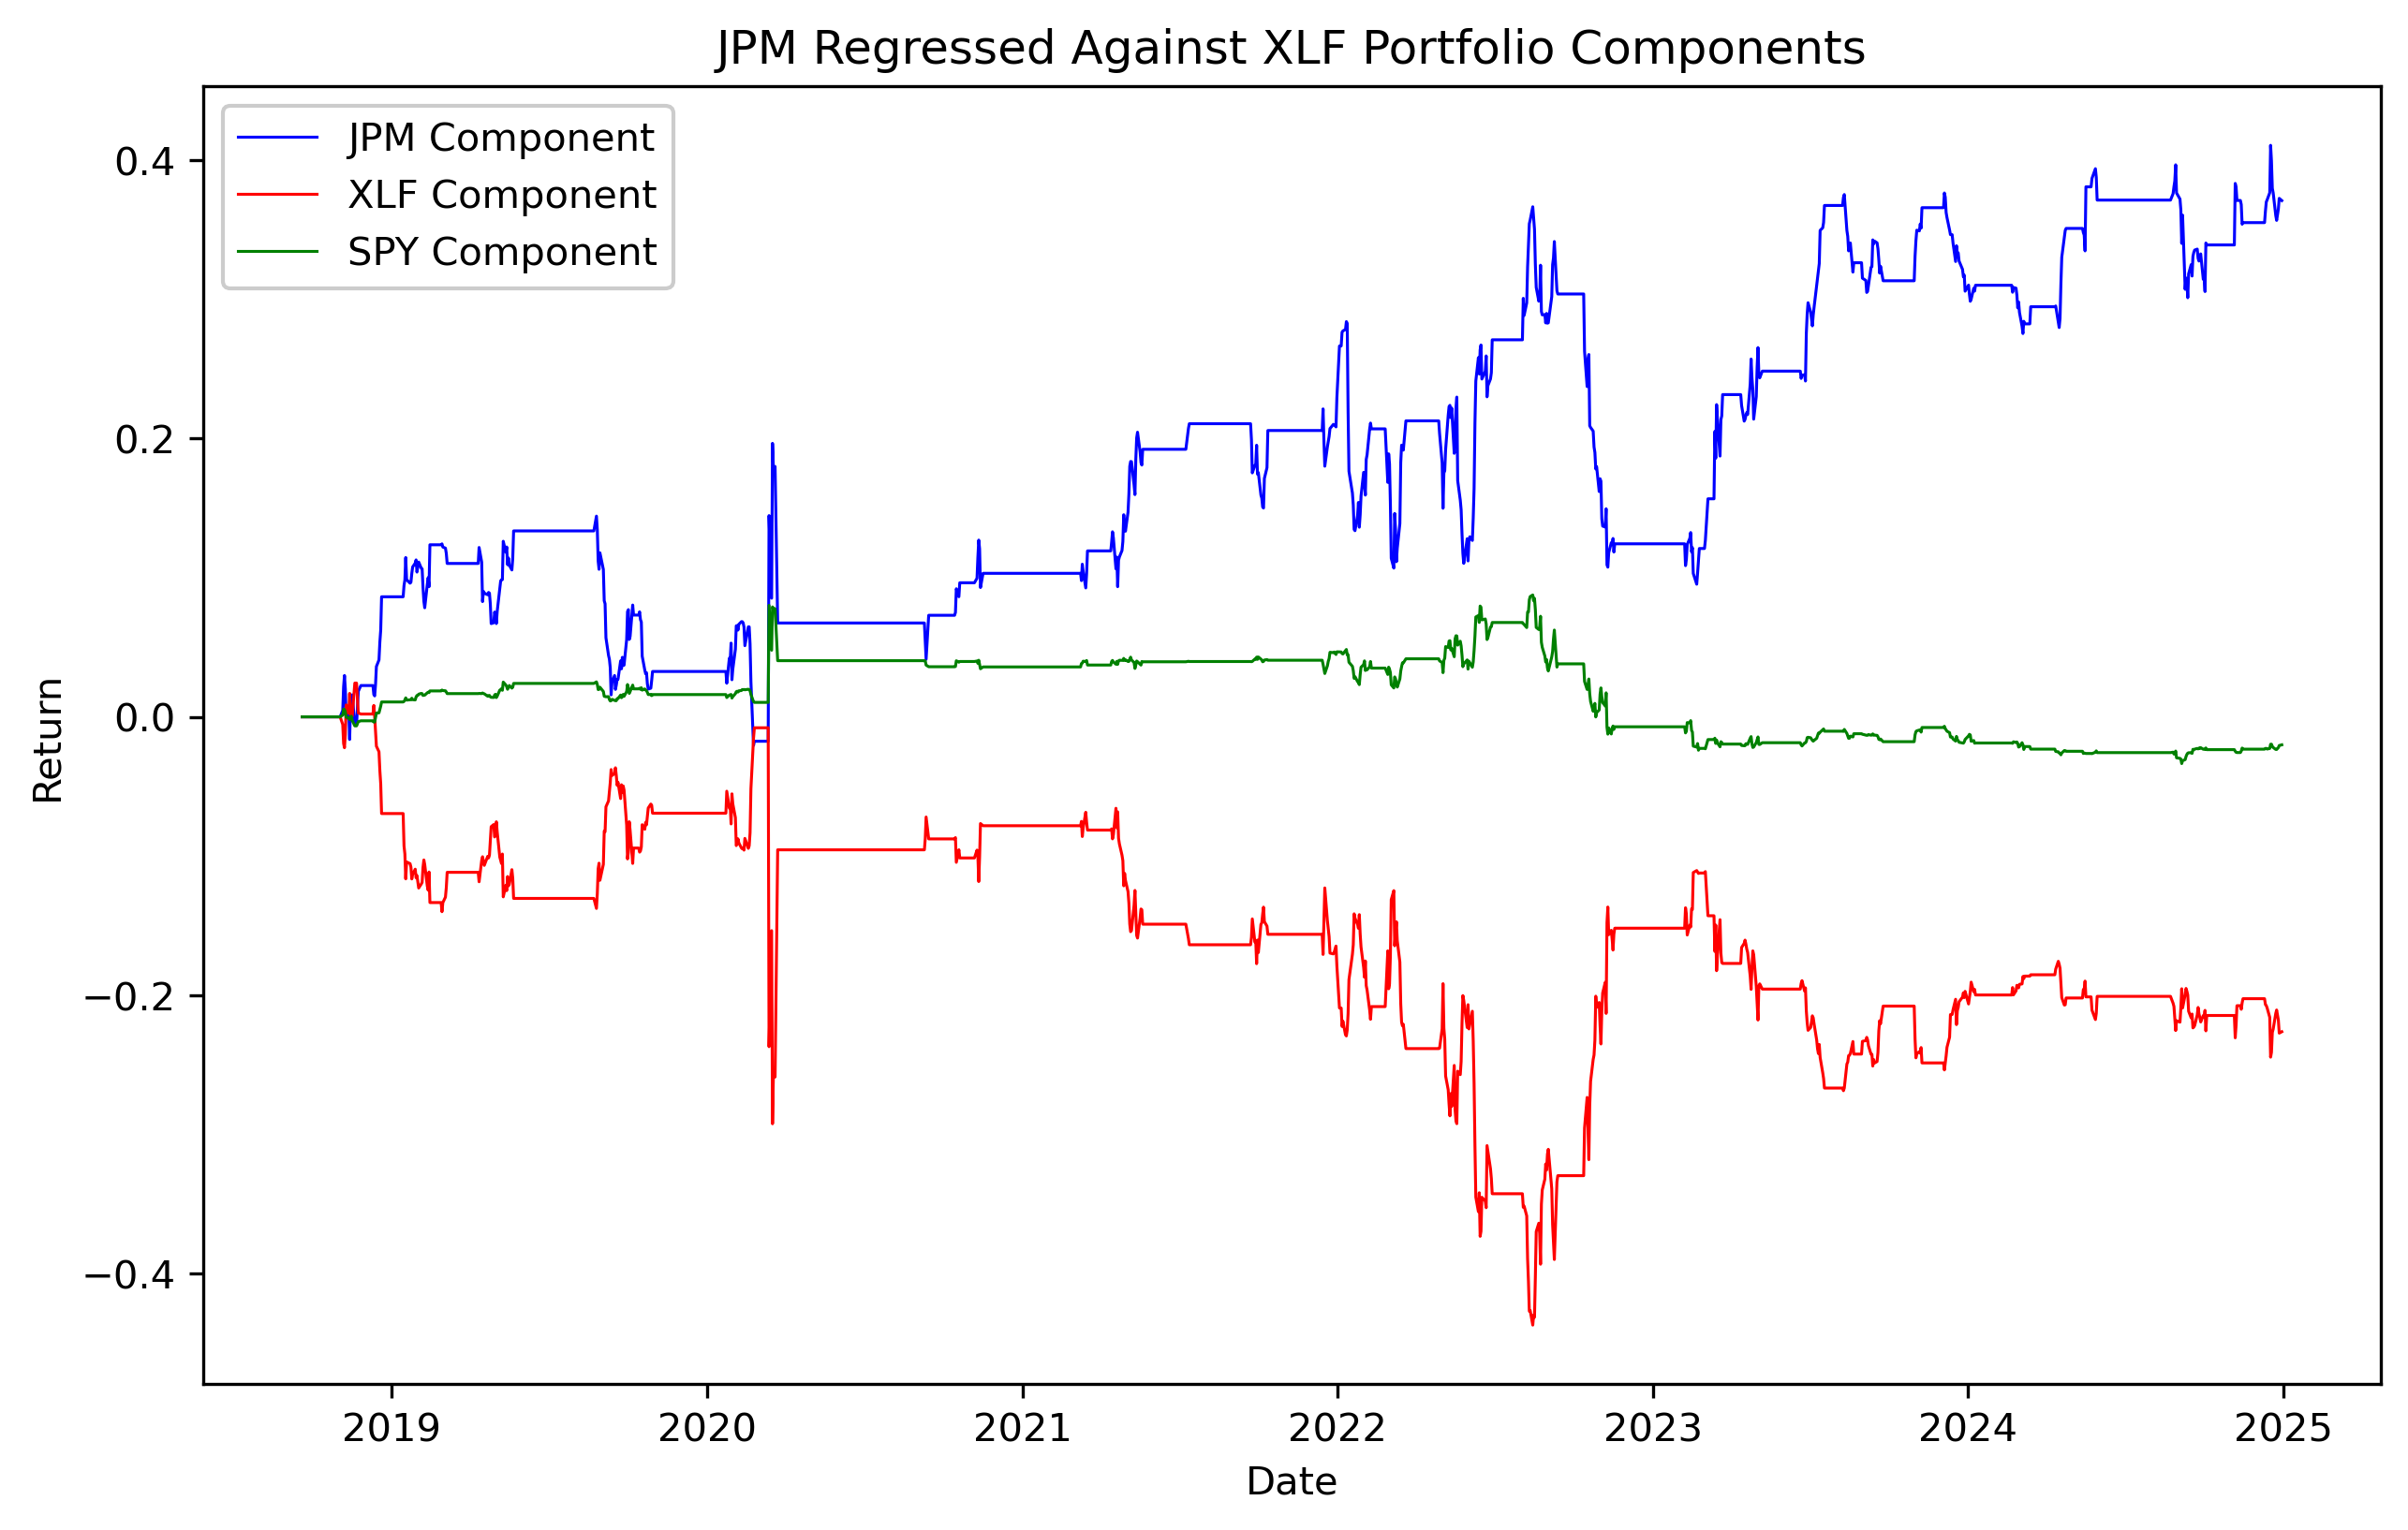

In [19]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(paramsRes_df.Date, np.cumsum(paramsRes_df.NextJPM * paramsRes_df.JPM_Pos), label="JPM Component", color='blue', linewidth=0.75)
plt.plot(paramsRes_df.Date, np.cumsum(paramsRes_df.NextXLF * paramsRes_df.XLF_Pos), label="XLF Component", color='red', linewidth=0.75)
plt.plot(paramsRes_df.Date, np.cumsum(paramsRes_df.NextSPY * paramsRes_df.SPY_Pos), label="SPY Component", color='green', linewidth=0.75)
plt.xlabel("Date")
plt.ylabel("Return")
plt.title('JPM Regressed Against XLF Portfolio Components')
plt.legend(framealpha=1, loc='upper left')
plt.show()

**Key Takeaway:** Hedging with the XLF ETF is decimating our potential gains. Here's what our return would have been if we hadn't hedged using the XLF ETF.

In [20]:
copyParamsRes_df['JPM_Pos'] = 0
copyParamsRes_df['SPY_Pos'] = 0

for i in range(1, len(copyParamsRes_df)):
    if copyParamsRes_df.OUK.iloc[i] > (252/30):
        if copyParamsRes_df.Score.iloc[i] >= 1.25:
            copyParamsRes_df.JPM_Pos.iloc[i] = -1
            copyParamsRes_df.SPY_Pos.iloc[i] = copyParamsRes_df.MacroBeta_SPY.iloc[i]
        elif copyParamsRes_df.Score.iloc[i] >= 0.75 and copyParamsRes_df.JPM_Pos.iloc[i-1] == -1:
            copyParamsRes_df.JPM_Pos.iloc[i] = -1
            copyParamsRes_df.SPY_Pos.iloc[i] = copyParamsRes_df.MacroBeta_SPY.iloc[i]

        if copyParamsRes_df.Score[i] <= -1.25:
            copyParamsRes_df.JPM_Pos.iloc[i] = 1
            copyParamsRes_df.SPY_Pos.iloc[i] = -1 * copyParamsRes_df.MacroBeta_SPY.iloc[i]
        elif copyParamsRes_df.Score.iloc[i] <= -0.5 and copyParamsRes_df.JPM_Pos.iloc[i-1] == 1:
            copyParamsRes_df.JPM_Pos.iloc[i] = 1
            copyParamsRes_df.SPY_Pos.iloc[i] = -1 * copyParamsRes_df.MacroBeta_SPY.iloc[i]

copyC2CLR['NextJPM'] = copyC2CLR['JPM'].shift(-1)
copyC2CLR['NextSPY'] = copyC2CLR['SPY'].shift(-1)
copyC2CLR.reset_index(inplace=True)

# Perform the left join on 'Date' column
copyParamsRes_df = pd.merge(copyParamsRes_df, copyC2CLR[['Date', 'NextJPM', 'NextSPY']], on='Date', how='left')

# Calculate return
copyParamsRes_df['Return'] = (copyParamsRes_df['NextJPM'] * copyParamsRes_df['JPM_Pos'] +
                       copyParamsRes_df['NextSPY'] * copyParamsRes_df['SPY_Pos'])

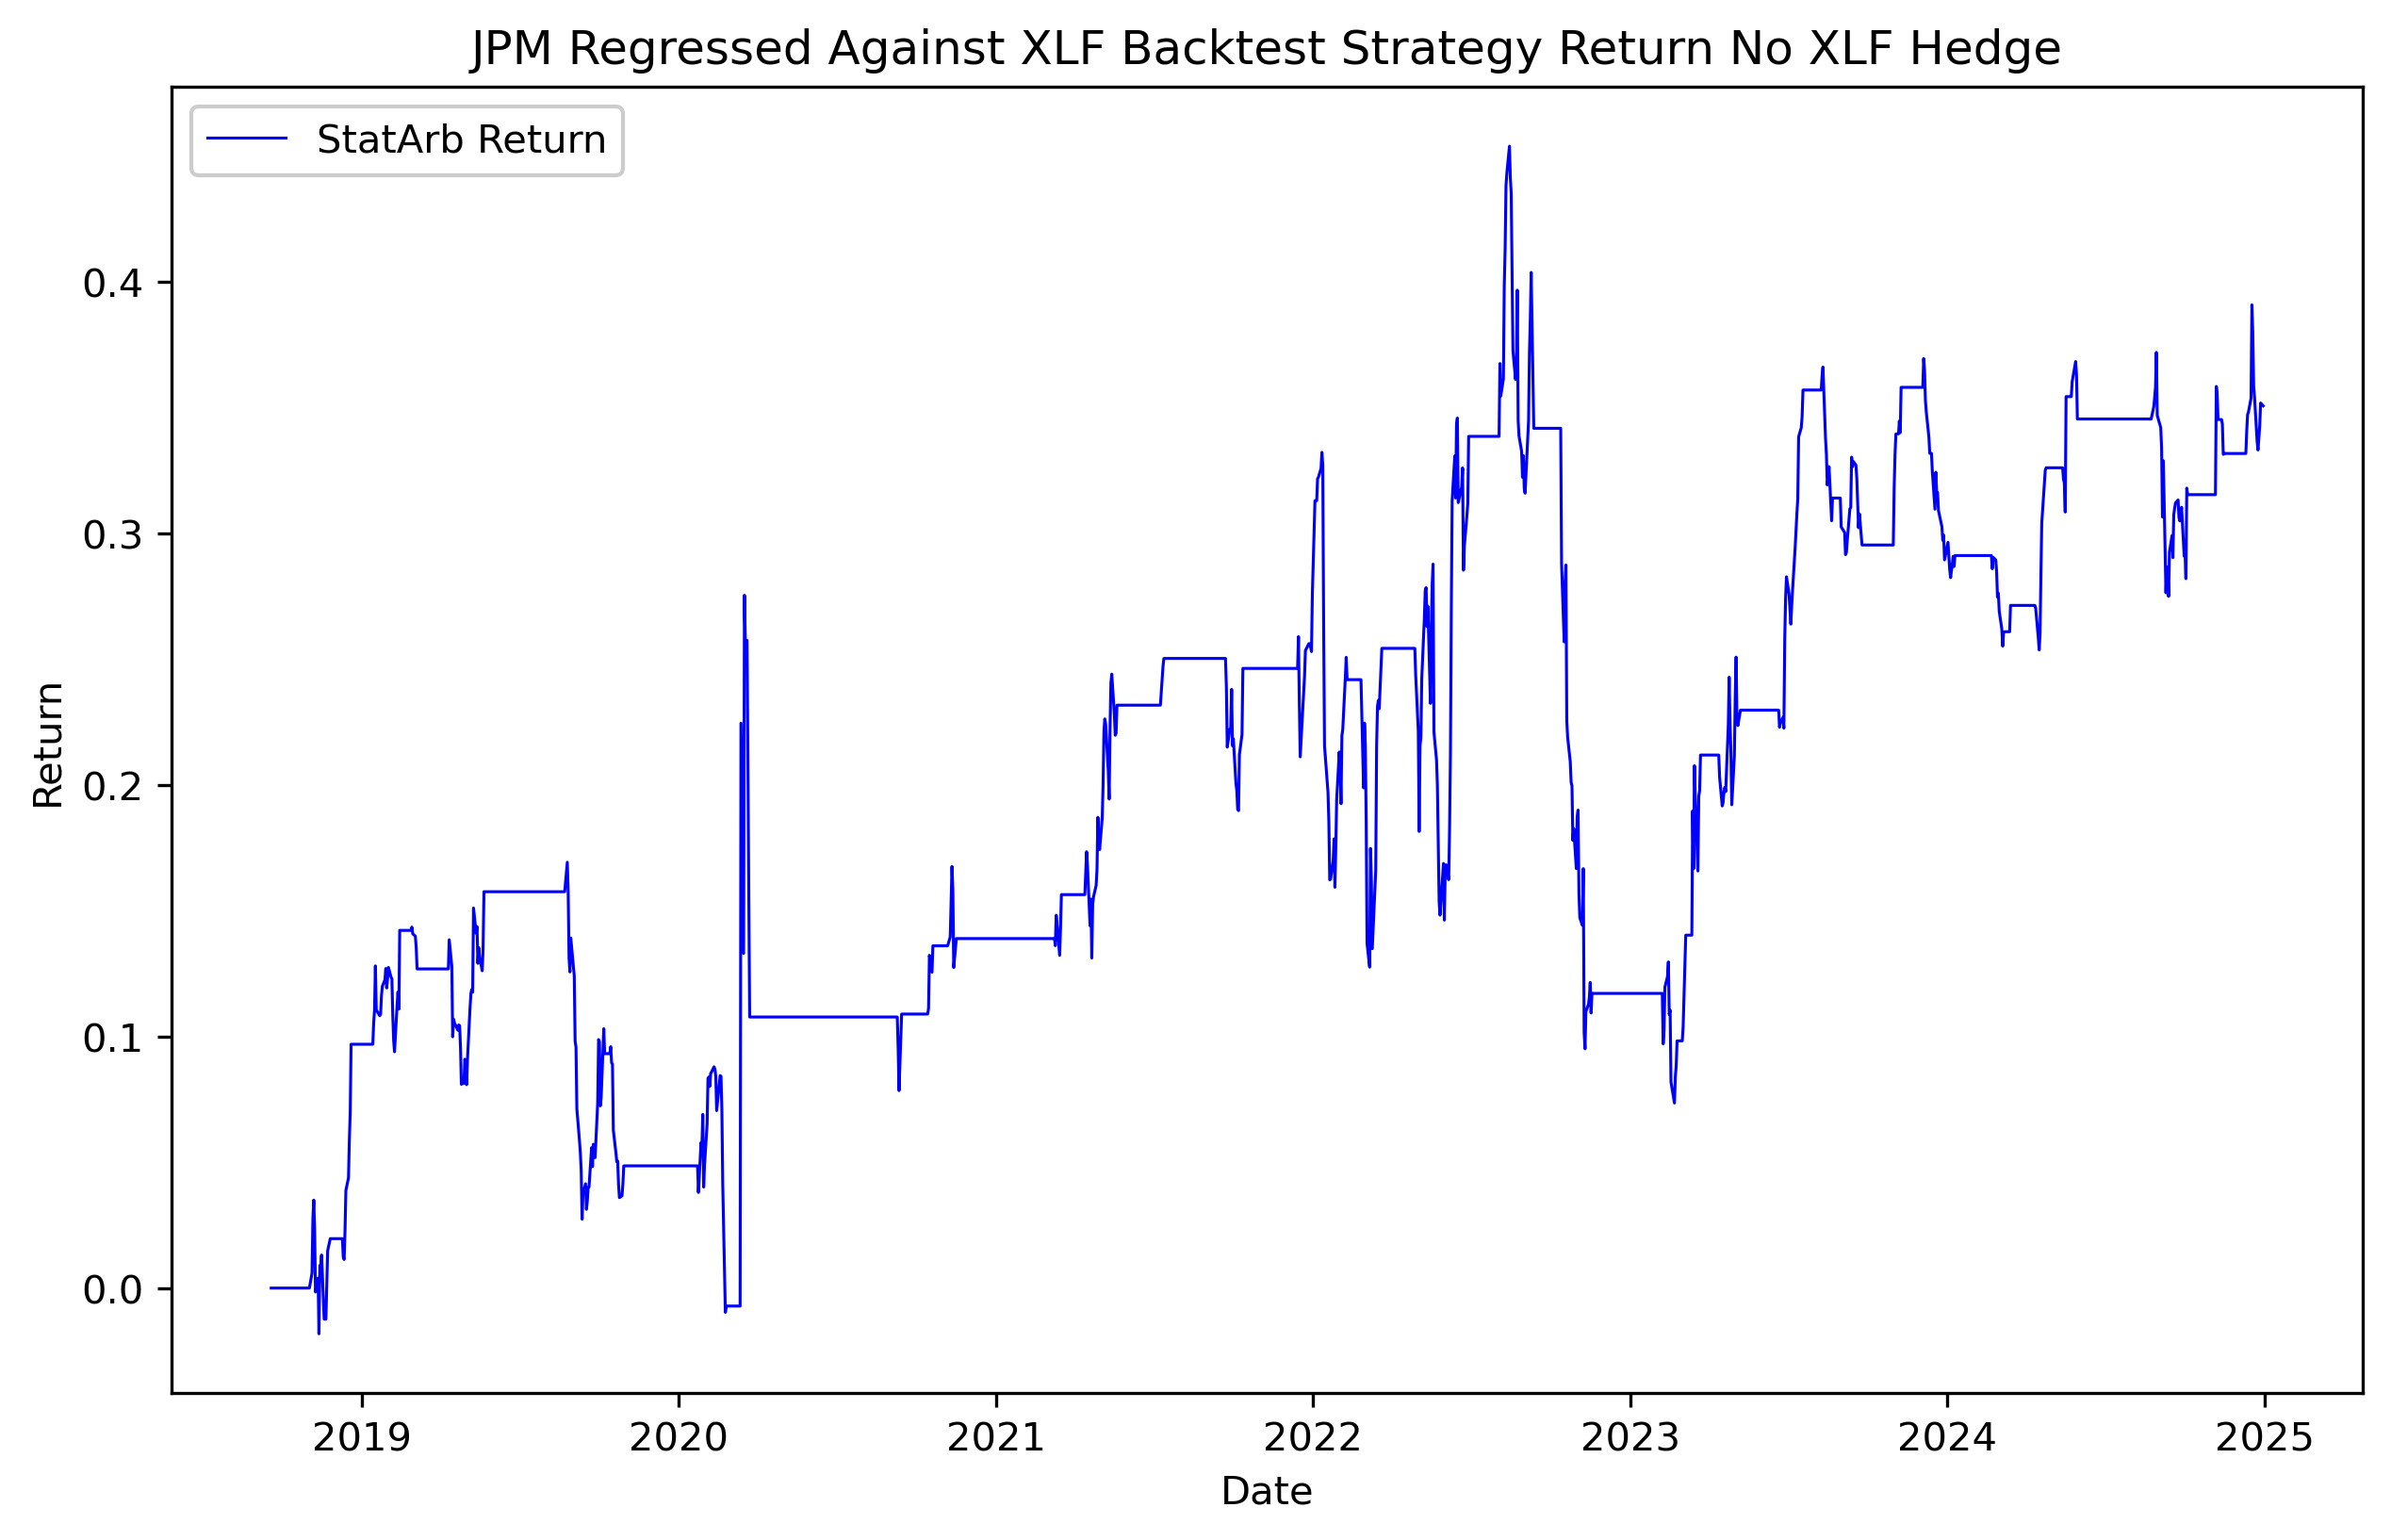

In [21]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(copyParamsRes_df.Date, np.cumsum(copyParamsRes_df.Return), label="StatArb Return", color='blue', linewidth=0.75)
plt.xlabel("Date")
plt.ylabel("Return")
plt.title('JPM Regressed Against XLF Backtest Strategy Return No XLF Hedge')
plt.legend(framealpha=1, loc='upper left')
plt.show()

In [22]:
print(f'Cumulative Return: {np.cumsum(copyParamsRes_df.Return).iloc[-1] * 100:.2f}%')
print(f'Sharpe Ratio: {copyParamsRes_df['Return'].mean() / copyParamsRes_df['Return'].std() * np.sqrt(252)}')
s = (copyParamsRes_df.Return+1).cumprod()
max_drawdown = np.ptp(s)/s.max()
print(f'Max Drawdown: {max_drawdown}')

Cumulative Return: 35.08%
Sharpe Ratio: 0.2694280311215714
Max Drawdown: 0.32707777959922607


**That's a massive improvement!** If we choose to ignore that we are taking on way more risk.